<div style="background: linear-gradient(to right,rgb(225, 231, 134),rgb(176, 238, 148),rgb(150, 232, 238)); padding: 20px; border-radius: 10px; text-align: center; box-shadow: 0 10px 20px rgba(0,0,0,0.19), 0 6px 6px rgba(0,0,0,0.23);">
    <span style="font-family: 'Montserrat', sans-serif; font-weight: 800; font-size: 2.5em; color: white; text-shadow: 2px 2px 4px #000;">✨ IMPORTS ✨</span>
</div>

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GroupKFold
import numpy as np
import matplotlib.pyplot as plt

from sklearn.metrics import precision_score, recall_score, f1_score, balanced_accuracy_score
import pickle
from collections import defaultdict
from sklearn.utils import shuffle
import os
import cv2
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms
import pandas as pd

from torchinfo import summary
from sklearn.metrics import confusion_matrix
import seaborn as sns



<div style="background: linear-gradient(to right,rgb(225, 231, 134),rgb(176, 238, 148),rgb(150, 232, 238)); padding: 20px; border-radius: 10px; text-align: center; box-shadow: 0 10px 20px rgba(0,0,0,0.19), 0 6px 6px rgba(0,0,0,0.23);">
    <span style="font-family: 'Montserrat', sans-serif; font-weight: 800; font-size: 2.5em; color: white; text-shadow: 2px 2px 4px #000;">✨ LOADING THE SPLIT DATA ARRAYS ✨</span>
</div>

<div style="background: linear-gradient(to right,rgb(225, 231, 134),rgb(176, 238, 148),rgb(150, 232, 238)); padding: 15px; border-radius: 8px; text-align: center; box-shadow: 0 8px 16px rgba(0,0,0,0.19), 0 4px 4px rgba(0,0,0,0.23);">
    <span style="font-family: 'Montserrat', sans-serif; font-weight: 700; font-size: 1.2em; color: white; text-shadow: 1px 1px 3px #000;">📁 reminder to change the folder path to your numpy array folder 📁</span>
</div>

In [2]:
import numpy as np
import os

# Define the folder path
folder_path = r"D:\PYTHONIG\newwindow\NOTEBOOKS_2025\aprilmay2025\data\numpy\cwtnormalized\concatenatedspectrograms"

# Load the numpy files into the respective arrays with the correct capitalized naming
eeg_fold_1 = np.load(os.path.join(folder_path, 'CWT_DATA_FOLD_fold_1.npy'))
labels_fold_1 = np.load(os.path.join(folder_path, 'CWT_LABELS_FOLD_fold_1.npy'))
patients_fold_1 = np.load(os.path.join(folder_path, 'CWT_PATIENTS_FOLD_fold_1.npy'))

eeg_fold_2 = np.load(os.path.join(folder_path, 'CWT_DATA_FOLD_fold_2.npy'))
labels_fold_2 = np.load(os.path.join(folder_path, 'CWT_LABELS_FOLD_fold_2.npy'))
patients_fold_2 = np.load(os.path.join(folder_path, 'CWT_PATIENTS_FOLD_fold_2.npy'))

eeg_fold_3 = np.load(os.path.join(folder_path, 'CWT_DATA_FOLD_fold_3.npy'))
labels_fold_3 = np.load(os.path.join(folder_path, 'CWT_LABELS_FOLD_fold_3.npy'))
patients_fold_3 = np.load(os.path.join(folder_path, 'CWT_PATIENTS_FOLD_fold_3.npy'))

eeg_fold_4 = np.load(os.path.join(folder_path, 'CWT_DATA_FOLD_fold_4.npy'))
labels_fold_4 = np.load(os.path.join(folder_path, 'CWT_LABELS_FOLD_fold_4.npy'))
patients_fold_4 = np.load(os.path.join(folder_path, 'CWT_PATIENTS_FOLD_fold_4.npy'))

eeg_fold_5 = np.load(os.path.join(folder_path, 'CWT_DATA_FOLD_fold_5.npy'))
labels_fold_5 = np.load(os.path.join(folder_path, 'CWT_LABELS_FOLD_fold_5.npy'))
patients_fold_5 = np.load(os.path.join(folder_path, 'CWT_PATIENTS_FOLD_fold_5.npy'))

eeg_folds = [eeg_fold_1, eeg_fold_2, eeg_fold_3, eeg_fold_4, eeg_fold_5]
labels_folds = [labels_fold_1, labels_fold_2, labels_fold_3, labels_fold_4, labels_fold_5]
patients_folds = [patients_fold_1, patients_fold_2, patients_fold_3, patients_fold_4, patients_fold_5]

for i in range(len(eeg_folds)):
    eeg_folds[i] = eeg_folds[i].astype(np.float16)

<div style="background: linear-gradient(to right,rgb(225, 231, 134),rgb(176, 238, 148),rgb(150, 232, 238)); padding: 15px; border-radius: 8px; text-align: center; box-shadow: 0 8px 16px rgba(0,0,0,0.19), 0 4px 4px rgba(0,0,0,0.23);">
    <span style="font-family: 'Montserrat', sans-serif; font-weight: 700; font-size: 1.2em; color: white; text-shadow: 1px 1px 3px #000;">data balancer & early stopping</span>
</div>

In [3]:
def data_balancer(data, labels, factor):
    # Count the number of samples in each class
    num_class_0 = np.sum(labels == 0)
    num_class_1 = np.sum(labels == 1)
    num_class_2 = np.sum(labels == 2)

    # Find the minimum number of samples across all classes
    min_samples = min(num_class_0, num_class_1, num_class_2)

    # Calculate the number of samples to take from each class
    samples_per_class = min_samples // factor

    # Randomly sample 'samples_per_class' from each class
    class_0_indices = np.random.choice(np.where(labels == 0)[0], samples_per_class, replace=False)
    class_1_indices = np.random.choice(np.where(labels == 1)[0], samples_per_class, replace=False)
    class_2_indices = np.random.choice(np.where(labels == 2)[0], samples_per_class, replace=False)

    # Combine balanced indices
    balanced_indices = np.concatenate((class_0_indices, class_1_indices, class_2_indices))

    # Shuffle the balanced indices
    np.random.shuffle(balanced_indices)

    # Create balanced training data and labels
    balanced_data = data[balanced_indices]
    balanced_labels = labels[balanced_indices]

    return balanced_data, balanced_labels

In [4]:
class EarlyStopping:
    def __init__(self, patience=5):
        """
        Initializes the early stopping mechanism based on divergence detection.

        Args:
            patience (int): Number of consecutive epochs with increasing validation loss
                            before stopping.
        """
        self.patience = patience
        self.best_loss = None
        self.counter = 0
        self.early_stop = False
        self.best_model_state = None

    def __call__(self, val_loss, model):
        """
        Checks if the validation loss is diverging and updates the state accordingly.

        Args:
            val_loss (float): Current epoch's validation loss.
            model (torch.nn.Module): The model being trained.
        """
        if self.best_loss is None or val_loss < self.best_loss:
            # Improvement detected
            self.best_loss = val_loss
            self.best_model_state = model.state_dict()
            self.counter = 0
        else:
            # Validation loss increased
            self.counter += 1
            if self.counter >= self.patience:
                print(f"Divergence detected. Stopping training after {self.counter} epochs.")
                self.early_stop = True

    def load_best_model(self, model):
        """
        Restores the model to the state with the lowest validation loss.

        Args:
            model (torch.nn.Module): The model to restore.
        """
        model.load_state_dict(self.best_model_state)




<div style="background: linear-gradient(to right,rgb(225, 231, 134),rgb(176, 238, 148),rgb(150, 232, 238)); padding: 15px; border-radius: 8px; text-align: center; box-shadow: 0 8px 16px rgba(0,0,0,0.19), 0 4px 4px rgba(0,0,0,0.23);">
    <span style="font-family: 'Montserrat', sans-serif; font-weight: 700; font-size: 1.2em; color: white; text-shadow: 1px 1px 3px #000;">Result plotting</span>
</div>

In [5]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import (
    confusion_matrix,
    precision_recall_curve,
    roc_curve,
    auc,
    f1_score,
    balanced_accuracy_score,
    classification_report,
)
from sklearn.preprocessing import label_binarize

def plot_metrics(labels, predictions, n_classes=3):
    """
    Plots and computes metrics for classification tasks.

    Args:
        labels (array-like): True labels.
        predictions (array-like): Predicted probabilities or class predictions.
        n_classes (int): Number of classes (default is 3 for multi-class classification).
    """
    # If predictions are probabilities, convert to class predictions
    if predictions.ndim > 1:
        predicted_classes = np.argmax(predictions, axis=1)
    else:
        predicted_classes = predictions

    # Confusion Matrix
    cm = confusion_matrix(labels, predicted_classes)
    plt.figure(figsize=(6, 4))
    sns.heatmap(cm, annot=True, fmt='g', cmap='Blues', cbar=False)
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    plt.show()

    # Class-wise Accuracy
    print("\nClass-wise Accuracy:")
    for d in range(n_classes):
        correct_preds = cm[d][d]
        total_true_samples = sum(cm[d])
        ratio_correct = correct_preds / total_true_samples if total_true_samples != 0 else 0
        print(f'Class {d}: Correct Predictions / Total True Samples = {correct_preds}/{total_true_samples} ({ratio_correct:.2%})')

    # Precision-Recall Curves and AUPRC
    print("\nPrecision-Recall Curves:")
    labels_binarized = label_binarize(labels, classes=np.arange(n_classes))
    auprcs = []
    for class_idx in range(n_classes):
        precision, recall, _ = precision_recall_curve(labels_binarized[:, class_idx], predictions[:, class_idx])
        auprc = auc(recall, precision)
        auprcs.append(auprc)
        plt.plot(recall, precision, label=f'Class {class_idx + 1} (AUPRC = {auprc:.2f})')

    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title('Precision-Recall Curves for each class')
    plt.legend(loc='best')
    plt.grid(True)
    plt.show()

    # ROC Curves and AUC
    print("\nROC Curves:")
    for class_idx in range(n_classes):
        fpr, tpr, _ = roc_curve(labels_binarized[:, class_idx], predictions[:, class_idx])
        roc_auc = auc(fpr, tpr)
        plt.plot(fpr, tpr, label=f'Class {class_idx + 1} (AUC = {roc_auc:.2f})')

    plt.plot([0, 1], [0, 1], 'k--', label='Random Guess')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curves for each class')
    plt.legend(loc='best')
    plt.grid(True)
    plt.show()

    # Mean F1 Score
    f1 = f1_score(labels, predicted_classes, average='macro')
    print(f"\nMean F1 Score: {f1:.4f}")

    # Balanced Accuracy
    balanced_acc = balanced_accuracy_score(labels, predicted_classes)
    print(f"Balanced Accuracy: {balanced_acc:.4f}")

    # Average AUPRC
    mean_auprc = np.mean(auprcs)
    print(f"Average AUPRC: {mean_auprc:.4f}")

    # Classification Report
    print("\nClassification Report:")
    print(classification_report(labels, predicted_classes))

    return {
        "confusion_matrix": cm,
        "class_wise_accuracy": [cm[d][d] / sum(cm[d]) if sum(cm[d]) != 0 else 0 for d in range(n_classes)],
        "mean_f1_score": f1,
        "balanced_accuracy": balanced_acc,
        "average_auprc": mean_auprc,
        "auprc_per_class": auprcs,
    }

<div style="background: linear-gradient(to right,rgb(225, 231, 134),rgb(238, 206, 148),rgb(238, 150, 150)); padding: 15px; border-radius: 8px; text-align: center; box-shadow: 0 8px 16px rgba(0,0,0,0.19), 0 4px 4px rgba(0,0,0,0.23);">
    <span style="font-family: 'Montserrat', sans-serif; font-weight: 700; font-size: 1.2em; color: white; text-shadow: 1px 1px 3px #000;">MODEL GOES HERE</span>
</div>

In [6]:
import torch
import torch.nn as nn

debug_mode_flag = False
# Set the device to GPU if available, otherwise use CPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

#set random seed for reproducibility
torch.manual_seed(42)
debug_mode_flag = False

class TransformerBlock(nn.Module):
    def __init__(self, embed_dim, num_heads, ff_dim, dropout_rate=0.1):
        super(TransformerBlock, self).__init__()
        self.att = nn.MultiheadAttention(embed_dim=embed_dim, num_heads=num_heads)
        self.ffn = nn.Sequential(
            nn.Linear(embed_dim, ff_dim),
            nn.ReLU(),
            nn.Linear(ff_dim, embed_dim)
        )
        self.layernorm1 = nn.LayerNorm(embed_dim)
        self.layernorm2 = nn.LayerNorm(embed_dim)
        self.dropout1 = nn.Dropout(dropout_rate)
        self.dropout2 = nn.Dropout(dropout_rate)

    def forward(self, x):
        attn_output, _ = self.att(x, x, x)
        attn_output = self.dropout1(attn_output)
        out1 = self.layernorm1(x + attn_output)
        ffn_output = self.ffn(out1)
        ffn_output = self.dropout2(ffn_output)
        return self.layernorm2(out1 + ffn_output)

class TransformerModel(nn.Module):
    def __init__(self, input_shape, num_classes, embed_dim=64, num_heads=2, ff_dim=64, num_transformer_blocks=2,dropout_rate=0.1):
        super(TransformerModel, self).__init__()
        self.reshape = nn.Flatten(start_dim=2)  # Reshaping as in TensorFlow's Reshape
        self.embedding = nn.Linear(input_shape[1] * input_shape[2], embed_dim)
        self.transformer_blocks = nn.ModuleList(
            [TransformerBlock(embed_dim, num_heads, ff_dim,dropout_rate=dropout_rate) for _ in range(num_transformer_blocks)]
        )
        self.global_avg_pool = nn.AdaptiveAvgPool1d(1)
        self.dropout = nn.Dropout(0.1)
        self.classifier = nn.Linear(embed_dim, num_classes)

    def forward(self, x):
        x = self.reshape(x)
        x = self.embedding(x)
        x = x.permute(1, 0, 2)  # PyTorch uses (seq_len, batch, embed_dim) format for transformers
        for transformer_block in self.transformer_blocks:
            x = transformer_block(x)
        x = x.permute(1, 2, 0)  # Back to (batch, embed_dim, seq_len)
        x = self.global_avg_pool(x).squeeze(-1)
        x = self.dropout(x)
        return self.classifier(x)


<div style="background: linear-gradient(to right,rgb(225, 231, 134),rgb(238, 206, 148),rgb(238, 150, 150)); padding: 15px; border-radius: 8px; text-align: center; box-shadow: 0 8px 16px rgba(0,0,0,0.19), 0 4px 4px rgba(0,0,0,0.23);">
    <span style="font-family: 'Montserrat', sans-serif; font-weight: 700; font-size: 1.2em; color: white; text-shadow: 1px 1px 3px #000;">Test with demo data & model Summary</span>
</div>

In [7]:
model  = TransformerModel(input_shape=(224,224,3),num_classes=3) # declare model here
randomdata = torch.randn((1,224,224,3))
output = model(randomdata)
output.shape

torch.Size([1, 3])

In [8]:
from torchinfo import summary

summary(model)

Layer (type:depth-idx)                                       Param #
TransformerModel                                             --
├─Flatten: 1-1                                               --
├─Linear: 1-2                                                43,072
├─ModuleList: 1-3                                            --
│    └─TransformerBlock: 2-1                                 --
│    │    └─MultiheadAttention: 3-1                          16,640
│    │    └─Sequential: 3-2                                  8,320
│    │    └─LayerNorm: 3-3                                   128
│    │    └─LayerNorm: 3-4                                   128
│    │    └─Dropout: 3-5                                     --
│    │    └─Dropout: 3-6                                     --
│    └─TransformerBlock: 2-2                                 --
│    │    └─MultiheadAttention: 3-7                          16,640
│    │    └─Sequential: 3-8                                  8,320
│    │    └─Lay

<div style="background: linear-gradient(to right,rgb(225, 231, 134),rgb(238, 206, 148),rgb(238, 150, 150)); padding: 15px; border-radius: 8px; text-align: center; box-shadow: 0 8px 16px rgba(0,0,0,0.19), 0 4px 4px rgba(0,0,0,0.23);">
    <span style="font-family: 'Montserrat', sans-serif; font-weight: 700; font-size: 1.2em; color: white; text-shadow: 1px 1px 3px #000;">Training Code</span>
</div>

Running experiment with parameters:0 {'trial': 33, 'accuracy': 0.4955, 'hyperparameters': {'ff_dim': 32, 'dropout_rate': 0.22443843372647287, 'embed_dim': 2048, 'learning_rate': 2.4511558646364287e-06, 'optimizer': 'Adam', 'weight_decay': 7.92277168064745e-06, 'batch_size': 16, 'num_heads': 8, 'num_transformer_blocks': 1}}
__________________________________________________
__________________________________________________
__________________________________________________
__________________________________________________
__________________________________________________
Fold No: 1
Epoch [1/100], Loss: 1.0948, Accuracy: 0.4191
Validation Loss: 0.9902, Validation Accuracy: 0.4181
Epoch [2/100], Loss: 1.0484, Accuracy: 0.5013
Validation Loss: 1.0373, Validation Accuracy: 0.4484
Epoch [3/100], Loss: 1.0326, Accuracy: 0.5323
Validation Loss: 1.1406, Validation Accuracy: 0.4127
Epoch [4/100], Loss: 1.0178, Accuracy: 0.5526
Validation Loss: 1.0082, Validation Accuracy: 0.4699
Epoch [5/100]

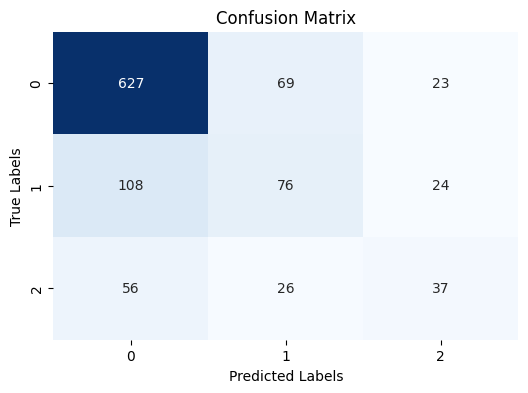


Class-wise Accuracy:
Class 0: Correct Predictions / Total True Samples = 627/719 (87.20%)
Class 1: Correct Predictions / Total True Samples = 76/208 (36.54%)
Class 2: Correct Predictions / Total True Samples = 37/119 (31.09%)

Precision-Recall Curves:


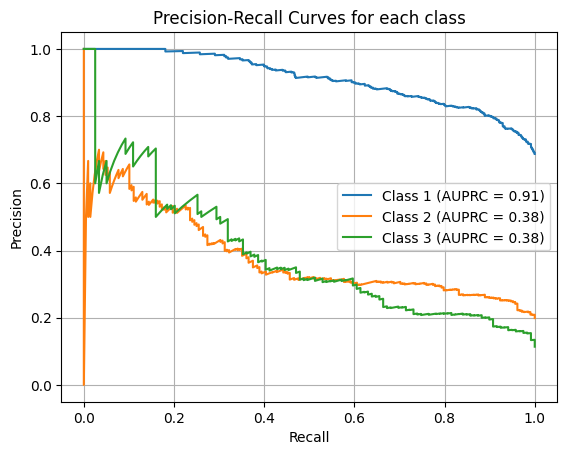


ROC Curves:


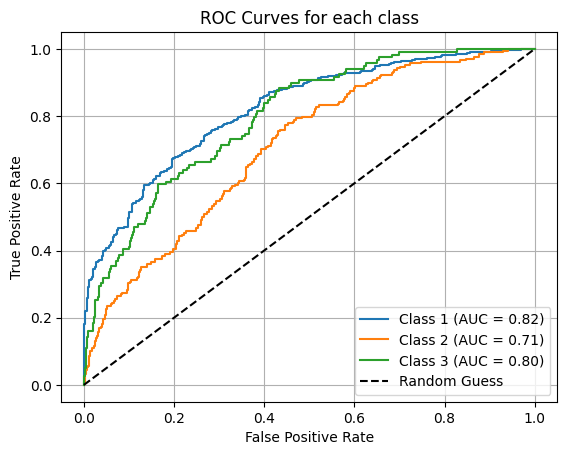


Mean F1 Score: 0.5320
Balanced Accuracy: 0.5161
Average AUPRC: 0.5561

Classification Report:
              precision    recall  f1-score   support

           0       0.79      0.87      0.83       719
           1       0.44      0.37      0.40       208
           2       0.44      0.31      0.36       119

    accuracy                           0.71      1046
   macro avg       0.56      0.52      0.53      1046
weighted avg       0.68      0.71      0.69      1046

Fold No: 2
Epoch [1/100], Loss: 1.1330, Accuracy: 0.4046
Validation Loss: 1.0336, Validation Accuracy: 0.4444
Epoch [2/100], Loss: 1.0697, Accuracy: 0.4635
Validation Loss: 0.9871, Validation Accuracy: 0.4947
Epoch [3/100], Loss: 1.0518, Accuracy: 0.5013
Validation Loss: 1.2197, Validation Accuracy: 0.4528
Epoch [4/100], Loss: 1.0343, Accuracy: 0.5312
Validation Loss: 1.1373, Validation Accuracy: 0.4577
Epoch [5/100], Loss: 0.9981, Accuracy: 0.5884
Validation Loss: 1.1222, Validation Accuracy: 0.5002
Epoch [6/100], Los

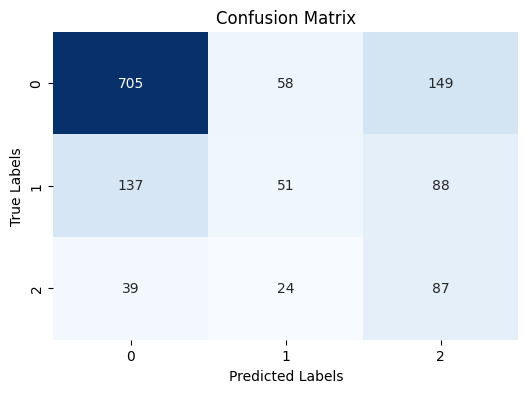


Class-wise Accuracy:
Class 0: Correct Predictions / Total True Samples = 705/912 (77.30%)
Class 1: Correct Predictions / Total True Samples = 51/276 (18.48%)
Class 2: Correct Predictions / Total True Samples = 87/150 (58.00%)

Precision-Recall Curves:


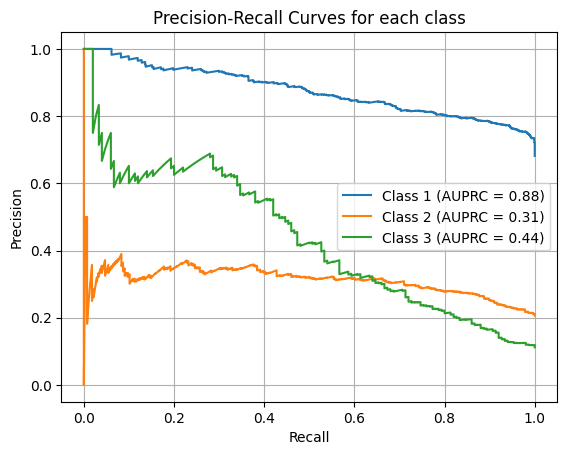


ROC Curves:


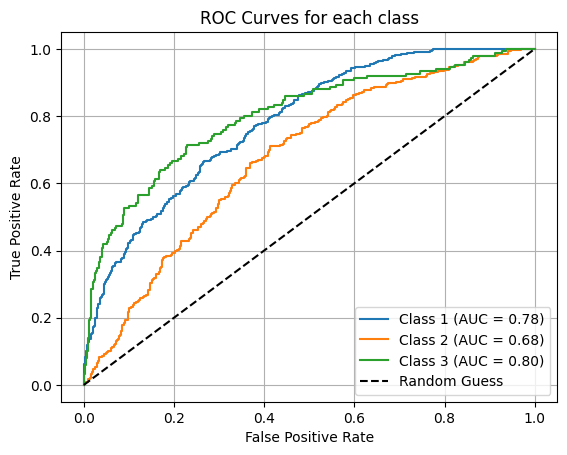


Mean F1 Score: 0.4676
Balanced Accuracy: 0.5126
Average AUPRC: 0.5405

Classification Report:
              precision    recall  f1-score   support

           0       0.80      0.77      0.79       912
           1       0.38      0.18      0.25       276
           2       0.27      0.58      0.37       150

    accuracy                           0.63      1338
   macro avg       0.48      0.51      0.47      1338
weighted avg       0.65      0.63      0.63      1338

Fold No: 3
Epoch [1/100], Loss: 1.1084, Accuracy: 0.4103
Validation Loss: 1.0869, Validation Accuracy: 0.4734
Epoch [2/100], Loss: 1.0700, Accuracy: 0.4600
Validation Loss: 1.0557, Validation Accuracy: 0.5478
Epoch [3/100], Loss: 1.0464, Accuracy: 0.5159
Validation Loss: 1.0085, Validation Accuracy: 0.5440
Epoch [4/100], Loss: 1.0150, Accuracy: 0.5602
Validation Loss: 0.9760, Validation Accuracy: 0.5376
Epoch [5/100], Loss: 1.0091, Accuracy: 0.5649
Validation Loss: 1.0331, Validation Accuracy: 0.5109
Epoch [6/100], Los

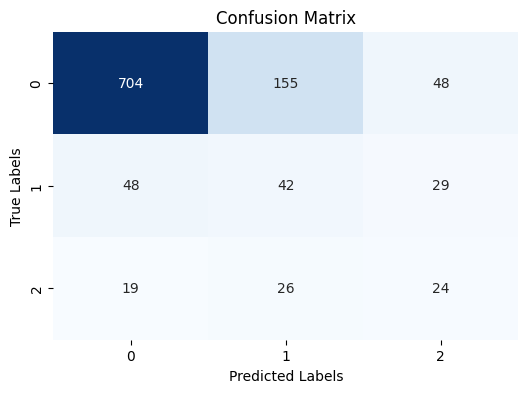


Class-wise Accuracy:
Class 0: Correct Predictions / Total True Samples = 704/907 (77.62%)
Class 1: Correct Predictions / Total True Samples = 42/119 (35.29%)
Class 2: Correct Predictions / Total True Samples = 24/69 (34.78%)

Precision-Recall Curves:


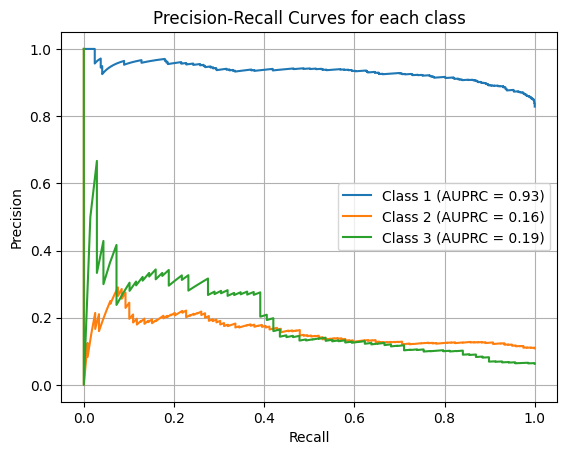


ROC Curves:


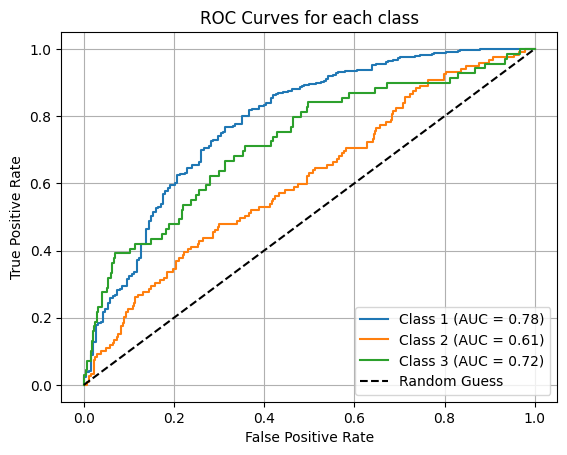


Mean F1 Score: 0.4557
Balanced Accuracy: 0.4923
Average AUPRC: 0.4274

Classification Report:
              precision    recall  f1-score   support

           0       0.91      0.78      0.84       907
           1       0.19      0.35      0.25       119
           2       0.24      0.35      0.28        69

    accuracy                           0.70      1095
   macro avg       0.45      0.49      0.46      1095
weighted avg       0.79      0.70      0.74      1095

Fold No: 4
Epoch [1/100], Loss: 1.1732, Accuracy: 0.3705
Validation Loss: 1.0923, Validation Accuracy: 0.4319
Epoch [2/100], Loss: 1.0751, Accuracy: 0.4473
Validation Loss: 1.0749, Validation Accuracy: 0.5062
Epoch [3/100], Loss: 1.0530, Accuracy: 0.5036
Validation Loss: 1.1152, Validation Accuracy: 0.5123
Epoch [4/100], Loss: 1.0210, Accuracy: 0.5495
Validation Loss: 1.0272, Validation Accuracy: 0.5412
Epoch [5/100], Loss: 1.0172, Accuracy: 0.5463
Validation Loss: 1.1121, Validation Accuracy: 0.5341
Epoch [6/100], Los

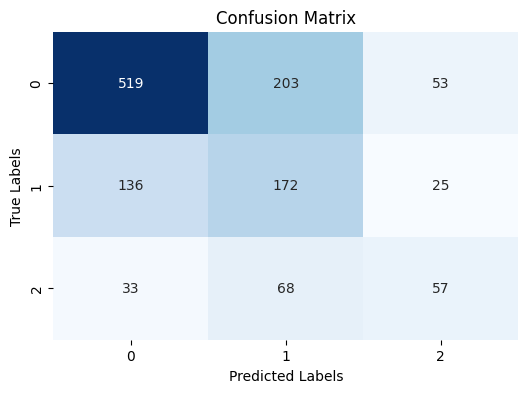


Class-wise Accuracy:
Class 0: Correct Predictions / Total True Samples = 519/775 (66.97%)
Class 1: Correct Predictions / Total True Samples = 172/333 (51.65%)
Class 2: Correct Predictions / Total True Samples = 57/158 (36.08%)

Precision-Recall Curves:


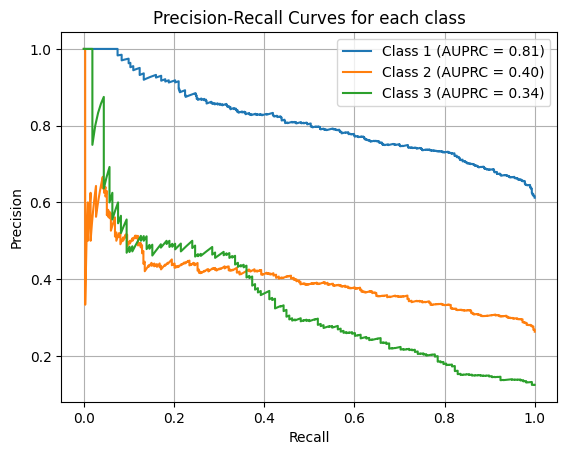


ROC Curves:


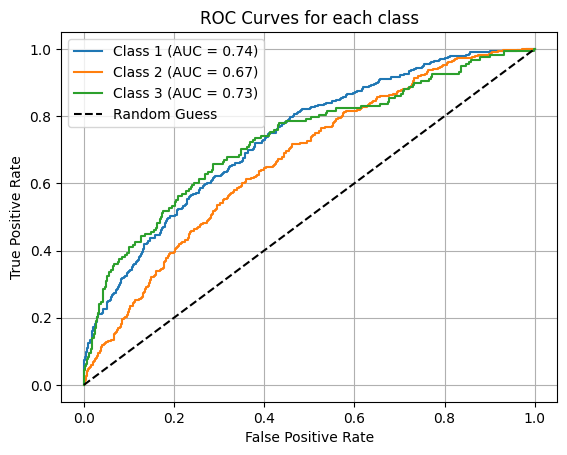


Mean F1 Score: 0.5140
Balanced Accuracy: 0.5157
Average AUPRC: 0.5179

Classification Report:
              precision    recall  f1-score   support

           0       0.75      0.67      0.71       775
           1       0.39      0.52      0.44       333
           2       0.42      0.36      0.39       158

    accuracy                           0.59      1266
   macro avg       0.52      0.52      0.51      1266
weighted avg       0.62      0.59      0.60      1266

Fold No: 5
Epoch [1/100], Loss: 1.1162, Accuracy: 0.4191
Validation Loss: 1.0091, Validation Accuracy: 0.4568
Epoch [2/100], Loss: 1.0360, Accuracy: 0.5266
Validation Loss: 1.2056, Validation Accuracy: 0.4832
Epoch [3/100], Loss: 1.0205, Accuracy: 0.5750
Validation Loss: 0.9735, Validation Accuracy: 0.4483
Epoch [4/100], Loss: 0.9848, Accuracy: 0.5996
Validation Loss: 0.9850, Validation Accuracy: 0.4957
Epoch [5/100], Loss: 0.9686, Accuracy: 0.6430
Validation Loss: 0.9789, Validation Accuracy: 0.5030
Epoch [6/100], Los

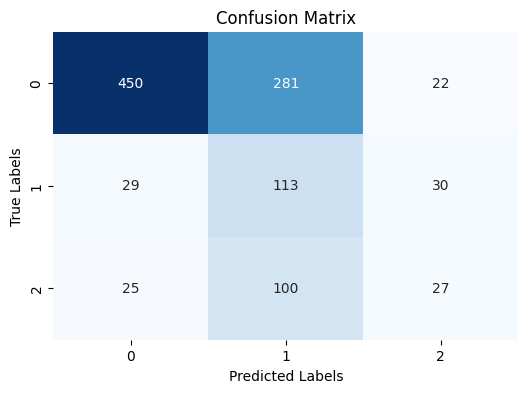


Class-wise Accuracy:
Class 0: Correct Predictions / Total True Samples = 450/753 (59.76%)
Class 1: Correct Predictions / Total True Samples = 113/172 (65.70%)
Class 2: Correct Predictions / Total True Samples = 27/152 (17.76%)

Precision-Recall Curves:


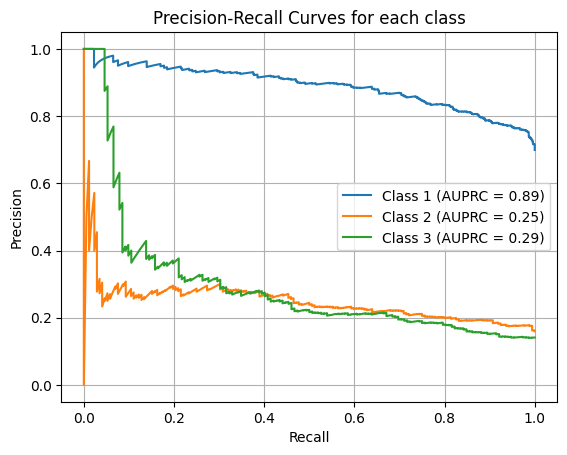


ROC Curves:


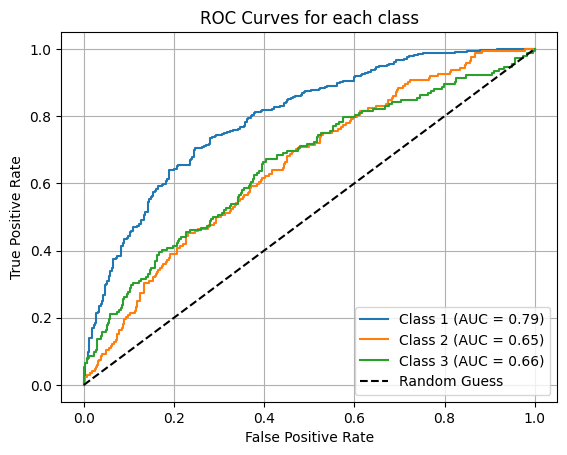


Mean F1 Score: 0.4297
Balanced Accuracy: 0.4774
Average AUPRC: 0.4756

Classification Report:
              precision    recall  f1-score   support

           0       0.89      0.60      0.72       753
           1       0.23      0.66      0.34       172
           2       0.34      0.18      0.23       152

    accuracy                           0.55      1077
   macro avg       0.49      0.48      0.43      1077
weighted avg       0.71      0.55      0.59      1077

Accuracy for each fold: [np.float64(0.5161178304637357), np.float64(0.5126029748283752), np.float64(0.49231749648231854), np.float64(0.5156511431807471), np.float64(0.47740596162880095)]
AUPRC for each fold: [np.float64(0.5560729533601595), np.float64(0.5404742027544805), np.float64(0.4273978534284335), np.float64(0.5179112700383606), np.float64(0.47555492105460173)]
Average AUPRC across all folds: 0.5034822401272072
Average Balanced Accuracy across all folds: 0.5028190813167955
Results saved to D:\PYTHONIG\newwindow\N

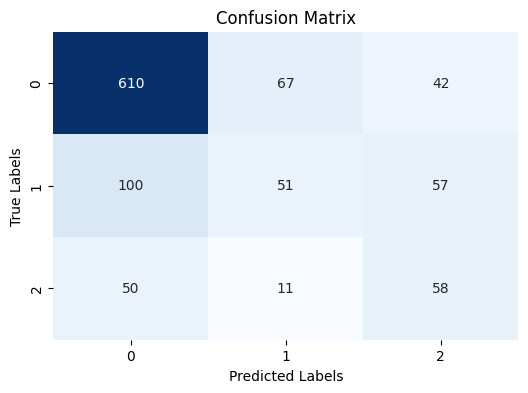


Class-wise Accuracy:
Class 0: Correct Predictions / Total True Samples = 610/719 (84.84%)
Class 1: Correct Predictions / Total True Samples = 51/208 (24.52%)
Class 2: Correct Predictions / Total True Samples = 58/119 (48.74%)

Precision-Recall Curves:


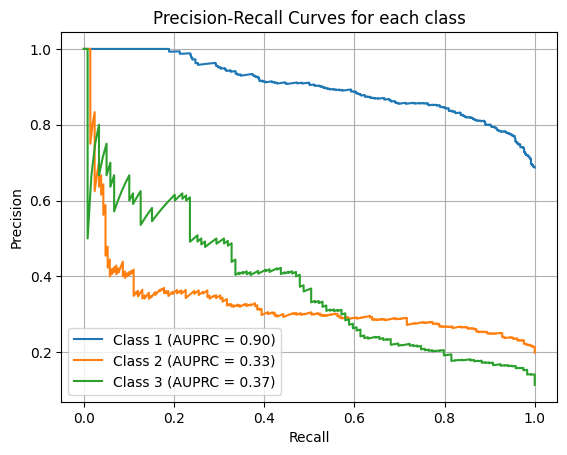


ROC Curves:


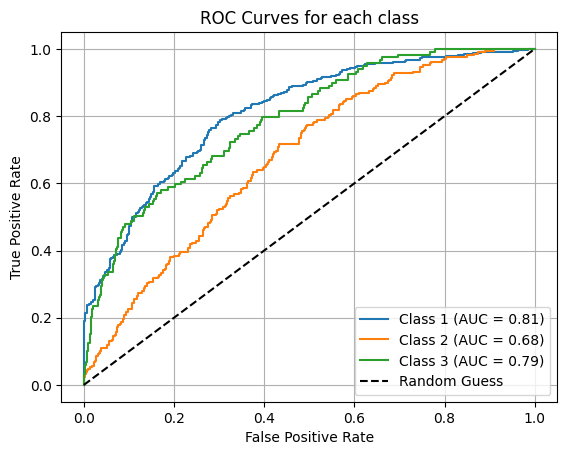


Mean F1 Score: 0.5159
Balanced Accuracy: 0.5270
Average AUPRC: 0.5352

Classification Report:
              precision    recall  f1-score   support

           0       0.80      0.85      0.82       719
           1       0.40      0.25      0.30       208
           2       0.37      0.49      0.42       119

    accuracy                           0.69      1046
   macro avg       0.52      0.53      0.52      1046
weighted avg       0.67      0.69      0.68      1046

Fold No: 2
Epoch [1/100], Loss: 1.1112, Accuracy: 0.3711
Validation Loss: 1.1069, Validation Accuracy: 0.4137
Epoch [2/100], Loss: 1.0808, Accuracy: 0.4196
Validation Loss: 1.0651, Validation Accuracy: 0.4169
Epoch [3/100], Loss: 1.0730, Accuracy: 0.4483
Validation Loss: 1.0504, Validation Accuracy: 0.4379
Epoch [4/100], Loss: 1.0557, Accuracy: 0.4834
Validation Loss: 1.0495, Validation Accuracy: 0.4599
Epoch [5/100], Loss: 1.0514, Accuracy: 0.4771
Validation Loss: 1.0827, Validation Accuracy: 0.4641
Epoch [6/100], Los

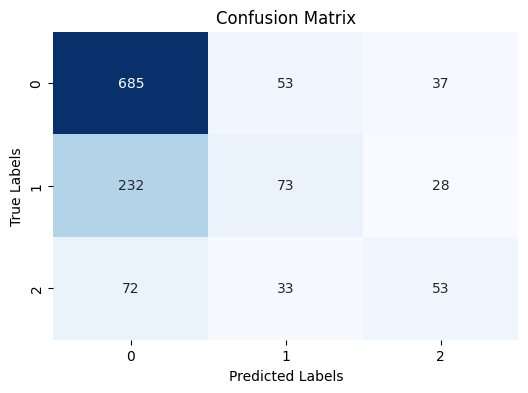


Class-wise Accuracy:
Class 0: Correct Predictions / Total True Samples = 685/775 (88.39%)
Class 1: Correct Predictions / Total True Samples = 73/333 (21.92%)
Class 2: Correct Predictions / Total True Samples = 53/158 (33.54%)

Precision-Recall Curves:


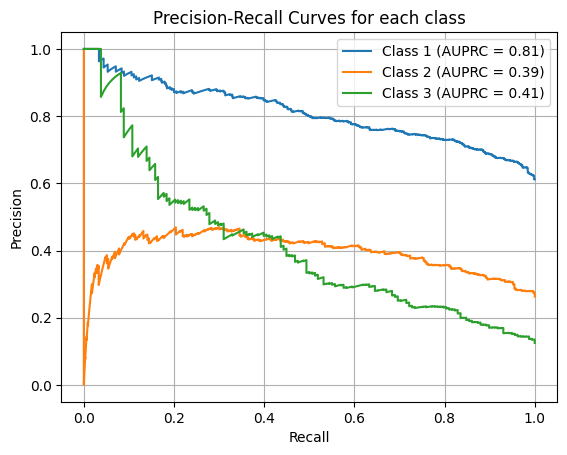


ROC Curves:


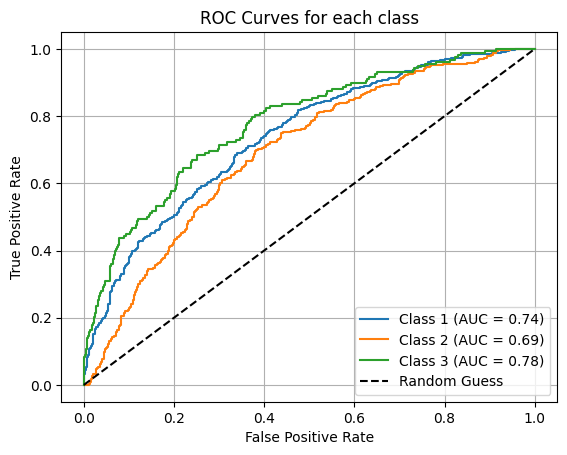


Mean F1 Score: 0.4858
Balanced Accuracy: 0.4795
Average AUPRC: 0.5377

Classification Report:
              precision    recall  f1-score   support

           0       0.69      0.88      0.78       775
           1       0.46      0.22      0.30       333
           2       0.45      0.34      0.38       158

    accuracy                           0.64      1266
   macro avg       0.53      0.48      0.49      1266
weighted avg       0.60      0.64      0.60      1266

Fold No: 3
Epoch [1/100], Loss: 1.1181, Accuracy: 0.3804
Validation Loss: 1.0850, Validation Accuracy: 0.3820
Epoch [2/100], Loss: 1.0872, Accuracy: 0.4333
Validation Loss: 1.0669, Validation Accuracy: 0.4176
Epoch [3/100], Loss: 1.0728, Accuracy: 0.4549
Validation Loss: 1.0341, Validation Accuracy: 0.3979
Epoch [4/100], Loss: 1.0628, Accuracy: 0.4618
Validation Loss: 1.1043, Validation Accuracy: 0.4196
Epoch [5/100], Loss: 1.0514, Accuracy: 0.4931
Validation Loss: 1.0654, Validation Accuracy: 0.4427
Epoch [6/100], Los

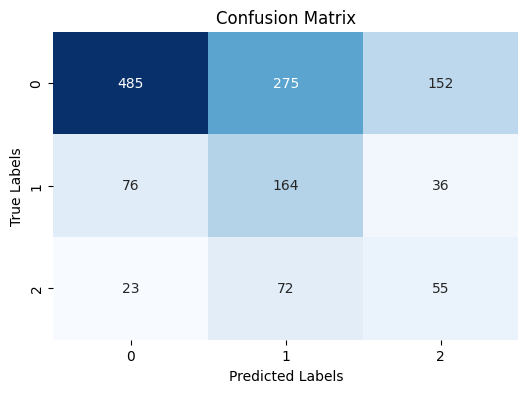


Class-wise Accuracy:
Class 0: Correct Predictions / Total True Samples = 485/912 (53.18%)
Class 1: Correct Predictions / Total True Samples = 164/276 (59.42%)
Class 2: Correct Predictions / Total True Samples = 55/150 (36.67%)

Precision-Recall Curves:


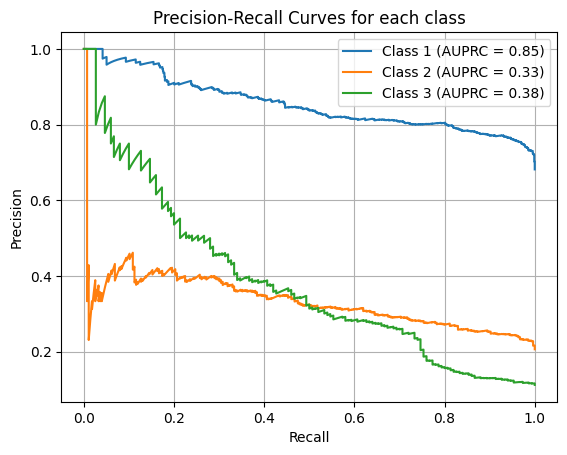


ROC Curves:


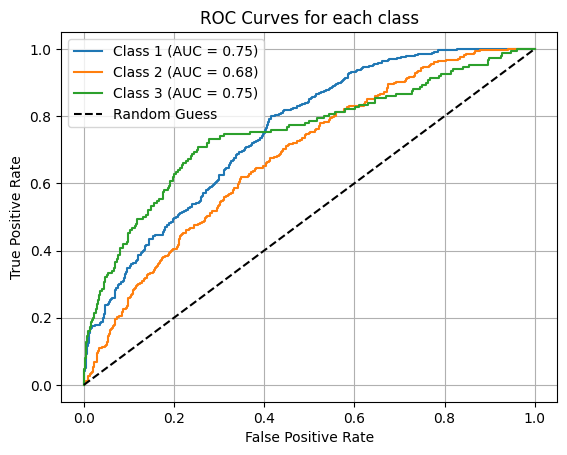


Mean F1 Score: 0.4484
Balanced Accuracy: 0.4976
Average AUPRC: 0.5226

Classification Report:
              precision    recall  f1-score   support

           0       0.83      0.53      0.65       912
           1       0.32      0.59      0.42       276
           2       0.23      0.37      0.28       150

    accuracy                           0.53      1338
   macro avg       0.46      0.50      0.45      1338
weighted avg       0.66      0.53      0.56      1338

Fold No: 4
Epoch [1/100], Loss: 1.1205, Accuracy: 0.3555
Validation Loss: 1.0305, Validation Accuracy: 0.3780
Epoch [2/100], Loss: 1.0996, Accuracy: 0.3854
Validation Loss: 1.1390, Validation Accuracy: 0.4534
Epoch [3/100], Loss: 1.0877, Accuracy: 0.4210
Validation Loss: 1.0703, Validation Accuracy: 0.4832
Epoch [4/100], Loss: 1.0778, Accuracy: 0.4432
Validation Loss: 1.0340, Validation Accuracy: 0.5155
Epoch [5/100], Loss: 1.0741, Accuracy: 0.4480
Validation Loss: 1.1391, Validation Accuracy: 0.4997
Epoch [6/100], Los

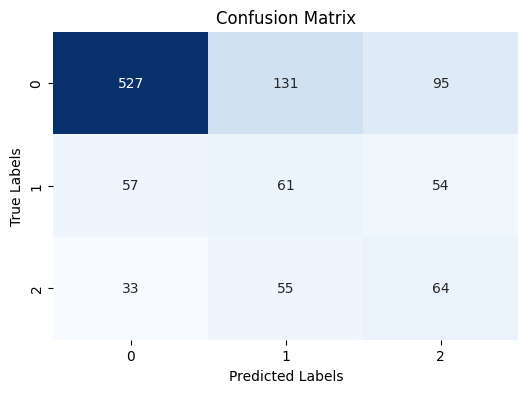


Class-wise Accuracy:
Class 0: Correct Predictions / Total True Samples = 527/753 (69.99%)
Class 1: Correct Predictions / Total True Samples = 61/172 (35.47%)
Class 2: Correct Predictions / Total True Samples = 64/152 (42.11%)

Precision-Recall Curves:


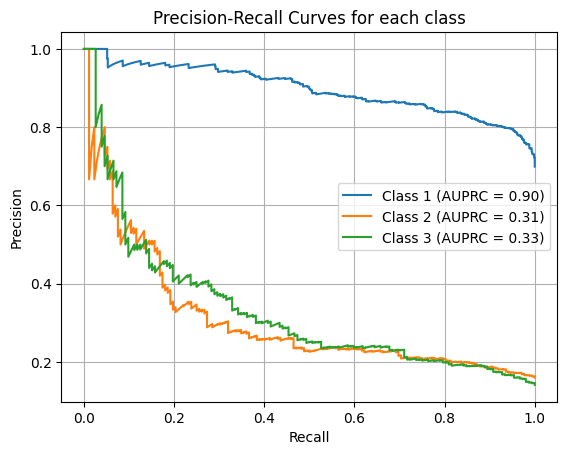


ROC Curves:


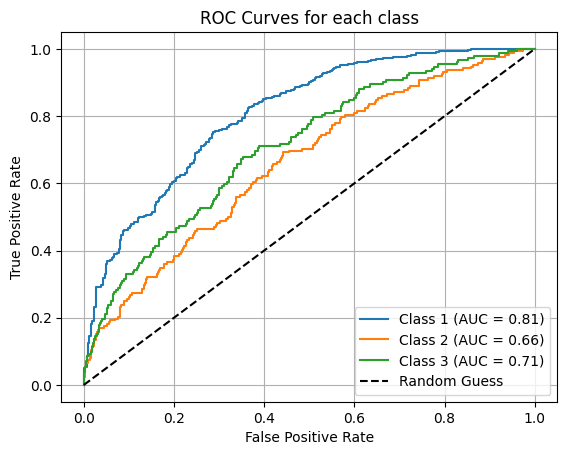


Mean F1 Score: 0.4704
Balanced Accuracy: 0.4919
Average AUPRC: 0.5106

Classification Report:
              precision    recall  f1-score   support

           0       0.85      0.70      0.77       753
           1       0.25      0.35      0.29       172
           2       0.30      0.42      0.35       152

    accuracy                           0.61      1077
   macro avg       0.47      0.49      0.47      1077
weighted avg       0.68      0.61      0.63      1077

Fold No: 5
Epoch [1/100], Loss: 1.0967, Accuracy: 0.4059
Validation Loss: 1.0590, Validation Accuracy: 0.4245
Epoch [2/100], Loss: 1.0739, Accuracy: 0.4559
Validation Loss: 1.1238, Validation Accuracy: 0.4141
Epoch [3/100], Loss: 1.0645, Accuracy: 0.4723
Validation Loss: 1.1017, Validation Accuracy: 0.4389
Epoch [4/100], Loss: 1.0477, Accuracy: 0.5215
Validation Loss: 1.0422, Validation Accuracy: 0.4453
Epoch [5/100], Loss: 1.0474, Accuracy: 0.5191
Validation Loss: 1.0320, Validation Accuracy: 0.4328
Epoch [6/100], Los

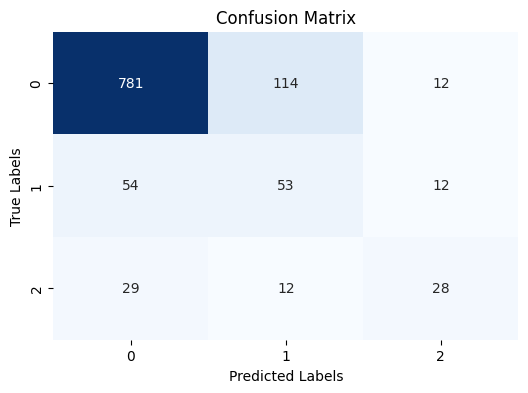


Class-wise Accuracy:
Class 0: Correct Predictions / Total True Samples = 781/907 (86.11%)
Class 1: Correct Predictions / Total True Samples = 53/119 (44.54%)
Class 2: Correct Predictions / Total True Samples = 28/69 (40.58%)

Precision-Recall Curves:


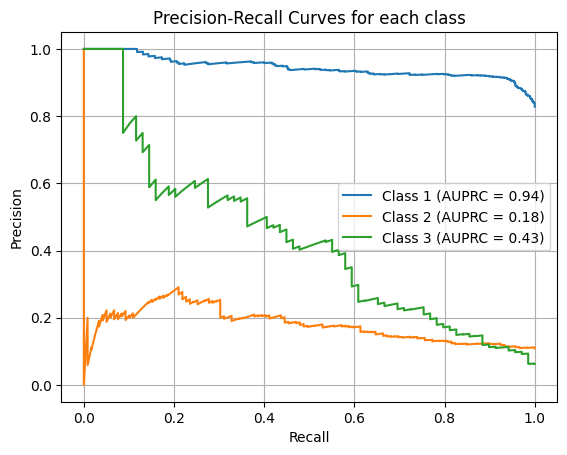


ROC Curves:


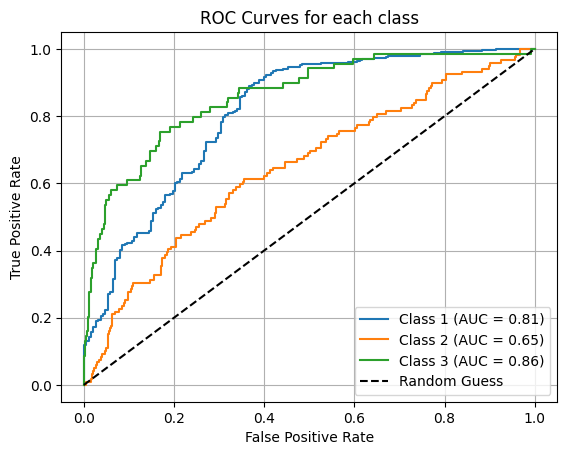


Mean F1 Score: 0.5668
Balanced Accuracy: 0.5708
Average AUPRC: 0.5166

Classification Report:
              precision    recall  f1-score   support

           0       0.90      0.86      0.88       907
           1       0.30      0.45      0.36       119
           2       0.54      0.41      0.46        69

    accuracy                           0.79      1095
   macro avg       0.58      0.57      0.57      1095
weighted avg       0.81      0.79      0.80      1095

Accuracy for each fold: [np.float64(0.5269959406679116), np.float64(0.47951107497861273), np.float64(0.4975559369438088), np.float64(0.491856997414937), np.float64(0.5707519126085153)]
AUPRC for each fold: [np.float64(0.535221630509603), np.float64(0.53768367225944), np.float64(0.5225659638035408), np.float64(0.510623208796504), np.float64(0.5165567529883228)]
Average AUPRC across all folds: 0.5245302456714821
Average Balanced Accuracy across all folds: 0.513334372522757
Results saved to D:\PYTHONIG\newwindow\NOTEBOOKS

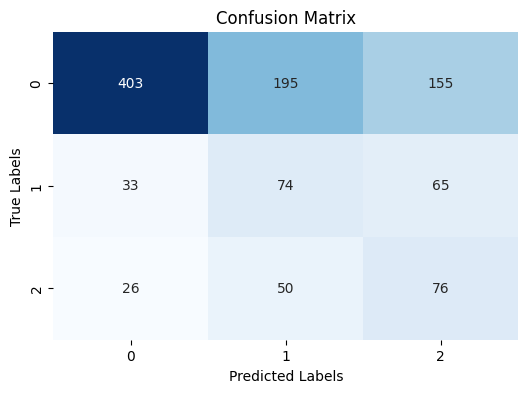


Class-wise Accuracy:
Class 0: Correct Predictions / Total True Samples = 403/753 (53.52%)
Class 1: Correct Predictions / Total True Samples = 74/172 (43.02%)
Class 2: Correct Predictions / Total True Samples = 76/152 (50.00%)

Precision-Recall Curves:


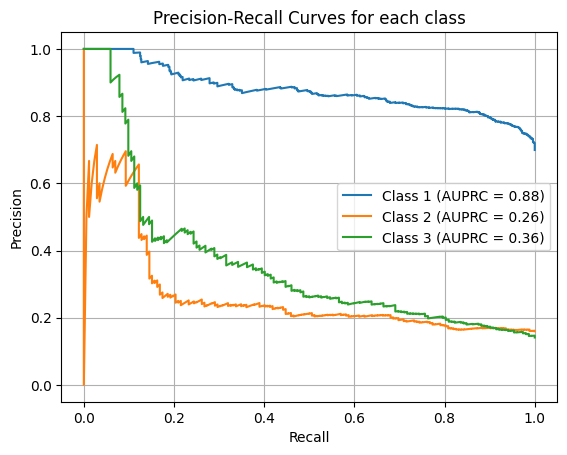


ROC Curves:


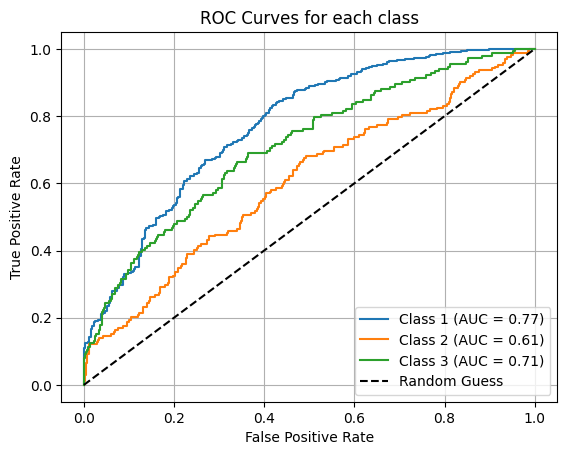


Mean F1 Score: 0.4347
Balanced Accuracy: 0.4885
Average AUPRC: 0.4987

Classification Report:
              precision    recall  f1-score   support

           0       0.87      0.54      0.66       753
           1       0.23      0.43      0.30       172
           2       0.26      0.50      0.34       152

    accuracy                           0.51      1077
   macro avg       0.45      0.49      0.43      1077
weighted avg       0.68      0.51      0.56      1077

Fold No: 2
Epoch [1/100], Loss: 1.0966, Accuracy: 0.4164
Validation Loss: 1.1077, Validation Accuracy: 0.3722
Epoch [2/100], Loss: 1.0709, Accuracy: 0.4509
Validation Loss: 1.0819, Validation Accuracy: 0.3946
Epoch [3/100], Loss: 1.0509, Accuracy: 0.5057
Validation Loss: 1.0485, Validation Accuracy: 0.4365
Epoch [4/100], Loss: 1.0451, Accuracy: 0.5066
Validation Loss: 1.0070, Validation Accuracy: 0.4353
Epoch [5/100], Loss: 1.0378, Accuracy: 0.5128
Validation Loss: 1.0537, Validation Accuracy: 0.4456
Epoch [6/100], Los

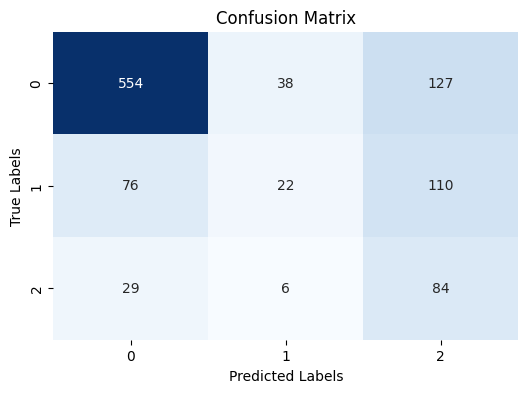


Class-wise Accuracy:
Class 0: Correct Predictions / Total True Samples = 554/719 (77.05%)
Class 1: Correct Predictions / Total True Samples = 22/208 (10.58%)
Class 2: Correct Predictions / Total True Samples = 84/119 (70.59%)

Precision-Recall Curves:


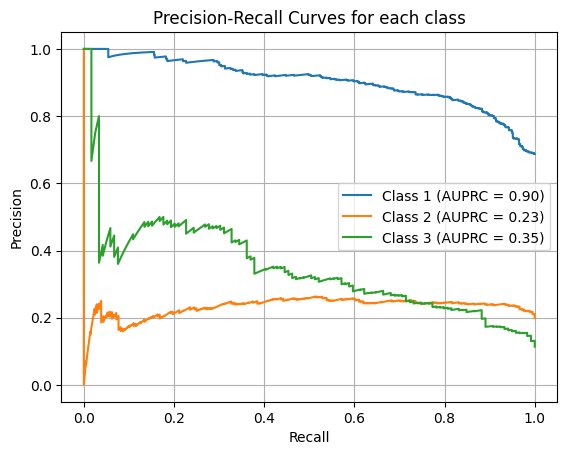


ROC Curves:


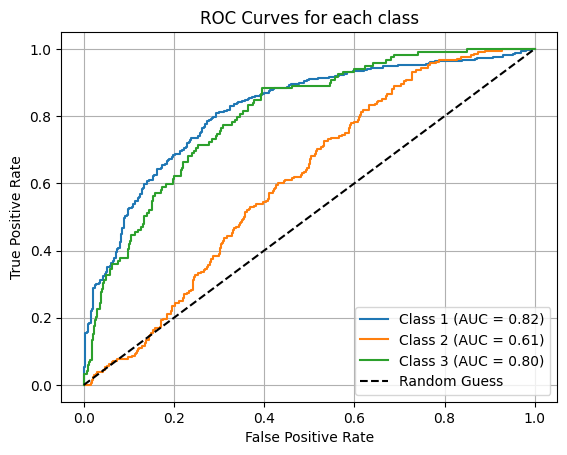


Mean F1 Score: 0.4488
Balanced Accuracy: 0.5274
Average AUPRC: 0.4940

Classification Report:
              precision    recall  f1-score   support

           0       0.84      0.77      0.80       719
           1       0.33      0.11      0.16       208
           2       0.26      0.71      0.38       119

    accuracy                           0.63      1046
   macro avg       0.48      0.53      0.45      1046
weighted avg       0.67      0.63      0.63      1046

Fold No: 3
Epoch [1/100], Loss: 1.1063, Accuracy: 0.3944
Validation Loss: 1.0630, Validation Accuracy: 0.4121
Epoch [2/100], Loss: 1.0760, Accuracy: 0.4573
Validation Loss: 1.0530, Validation Accuracy: 0.4104
Epoch [3/100], Loss: 1.0693, Accuracy: 0.4735
Validation Loss: 1.0700, Validation Accuracy: 0.4351
Epoch [4/100], Loss: 1.0561, Accuracy: 0.4726
Validation Loss: 1.0892, Validation Accuracy: 0.4371
Epoch [5/100], Loss: 1.0531, Accuracy: 0.4780
Validation Loss: 1.0316, Validation Accuracy: 0.4518
Epoch [6/100], Los

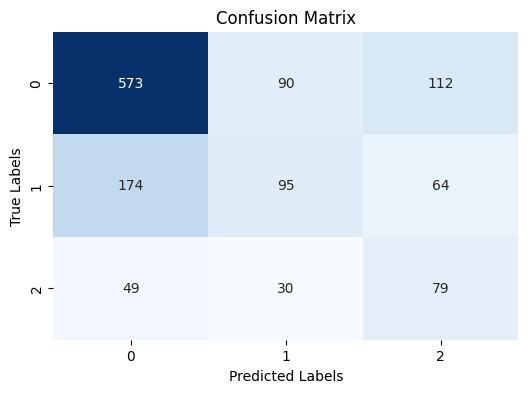


Class-wise Accuracy:
Class 0: Correct Predictions / Total True Samples = 573/775 (73.94%)
Class 1: Correct Predictions / Total True Samples = 95/333 (28.53%)
Class 2: Correct Predictions / Total True Samples = 79/158 (50.00%)

Precision-Recall Curves:


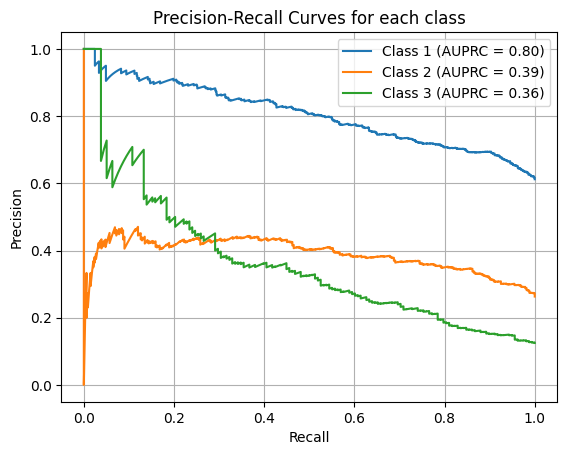


ROC Curves:


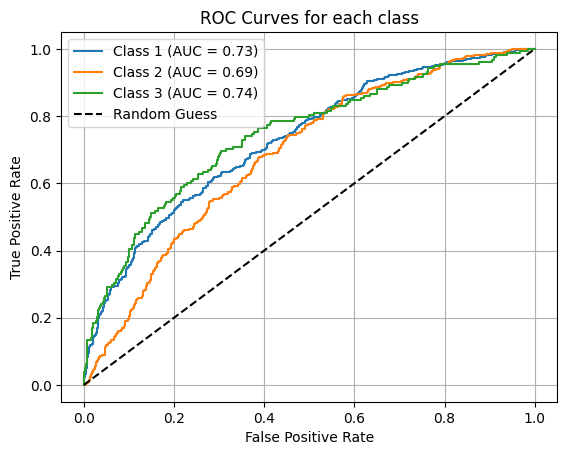


Mean F1 Score: 0.4863
Balanced Accuracy: 0.5082
Average AUPRC: 0.5178

Classification Report:
              precision    recall  f1-score   support

           0       0.72      0.74      0.73       775
           1       0.44      0.29      0.35       333
           2       0.31      0.50      0.38       158

    accuracy                           0.59      1266
   macro avg       0.49      0.51      0.49      1266
weighted avg       0.60      0.59      0.59      1266

Fold No: 4
Epoch [1/100], Loss: 1.1087, Accuracy: 0.3674
Validation Loss: 1.1070, Validation Accuracy: 0.4069
Epoch [2/100], Loss: 1.0855, Accuracy: 0.4086
Validation Loss: 1.0777, Validation Accuracy: 0.4624
Epoch [3/100], Loss: 1.0667, Accuracy: 0.4529
Validation Loss: 1.0722, Validation Accuracy: 0.4803
Epoch [4/100], Loss: 1.0544, Accuracy: 0.4901
Validation Loss: 1.0717, Validation Accuracy: 0.5180
Epoch [5/100], Loss: 1.0414, Accuracy: 0.5020
Validation Loss: 1.0415, Validation Accuracy: 0.5010
Epoch [6/100], Los

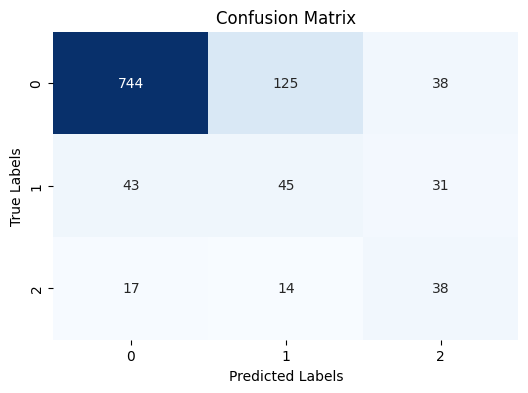


Class-wise Accuracy:
Class 0: Correct Predictions / Total True Samples = 744/907 (82.03%)
Class 1: Correct Predictions / Total True Samples = 45/119 (37.82%)
Class 2: Correct Predictions / Total True Samples = 38/69 (55.07%)

Precision-Recall Curves:


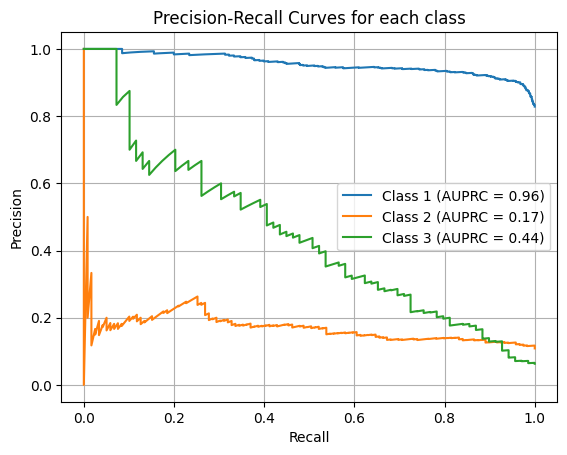


ROC Curves:


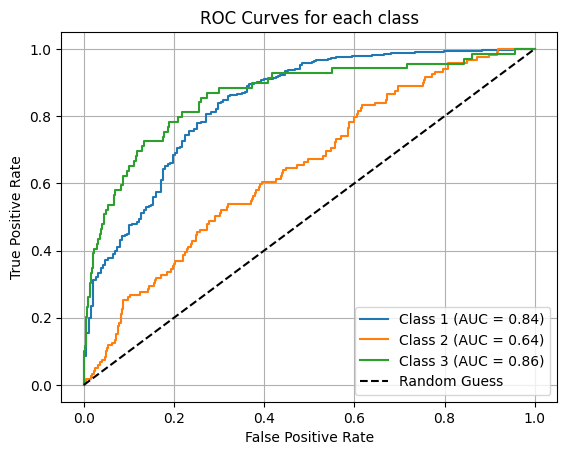


Mean F1 Score: 0.5328
Balanced Accuracy: 0.5831
Average AUPRC: 0.5220

Classification Report:
              precision    recall  f1-score   support

           0       0.93      0.82      0.87       907
           1       0.24      0.38      0.30       119
           2       0.36      0.55      0.43        69

    accuracy                           0.76      1095
   macro avg       0.51      0.58      0.53      1095
weighted avg       0.82      0.76      0.78      1095

Fold No: 5
Epoch [1/100], Loss: 1.1108, Accuracy: 0.3613
Validation Loss: 1.1490, Validation Accuracy: 0.4214
Epoch [2/100], Loss: 1.0931, Accuracy: 0.4048
Validation Loss: 1.0988, Validation Accuracy: 0.4614
Epoch [3/100], Loss: 1.0836, Accuracy: 0.4367
Validation Loss: 1.0113, Validation Accuracy: 0.5331
Epoch [4/100], Loss: 1.0586, Accuracy: 0.4747
Validation Loss: 1.0627, Validation Accuracy: 0.5257
Epoch [5/100], Loss: 1.0552, Accuracy: 0.4895
Validation Loss: 1.0357, Validation Accuracy: 0.5154
Epoch [6/100], Los

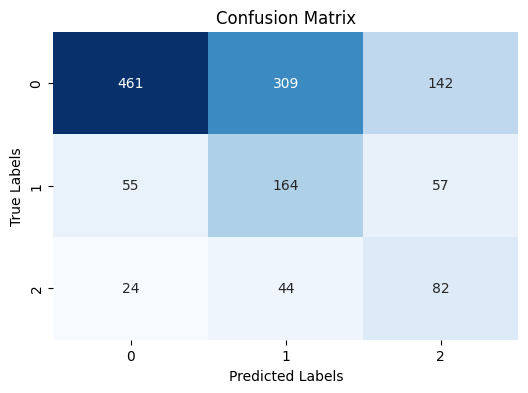


Class-wise Accuracy:
Class 0: Correct Predictions / Total True Samples = 461/912 (50.55%)
Class 1: Correct Predictions / Total True Samples = 164/276 (59.42%)
Class 2: Correct Predictions / Total True Samples = 82/150 (54.67%)

Precision-Recall Curves:


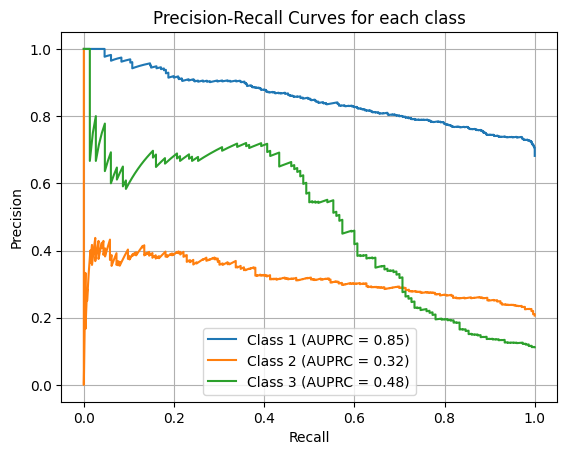


ROC Curves:


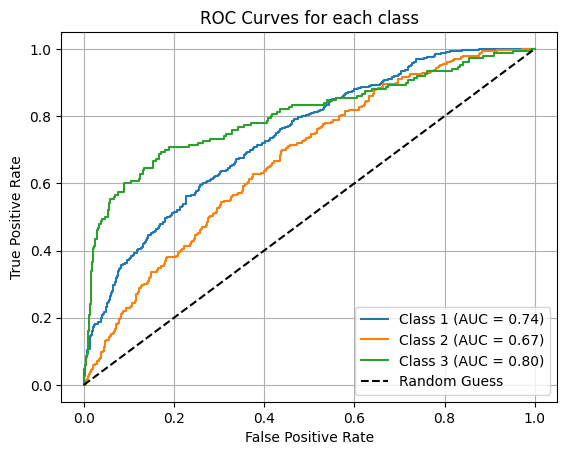


Mean F1 Score: 0.4764
Balanced Accuracy: 0.5488
Average AUPRC: 0.5510

Classification Report:
              precision    recall  f1-score   support

           0       0.85      0.51      0.63       912
           1       0.32      0.59      0.41       276
           2       0.29      0.55      0.38       150

    accuracy                           0.53      1338
   macro avg       0.49      0.55      0.48      1338
weighted avg       0.68      0.53      0.56      1338

Accuracy for each fold: [np.float64(0.488475040406848), np.float64(0.5273887291088469), np.float64(0.5082133746649876), np.float64(0.5830541858339297), np.float64(0.5487840071192475)]
AUPRC for each fold: [np.float64(0.49871433626230816), np.float64(0.4939795661664163), np.float64(0.5178322515693129), np.float64(0.5220249308336501), np.float64(0.5510377196115533)]
Average AUPRC across all folds: 0.5167177608886482
Average Balanced Accuracy across all folds: 0.5311830674267719
Results saved to D:\PYTHONIG\newwindow\NOTE

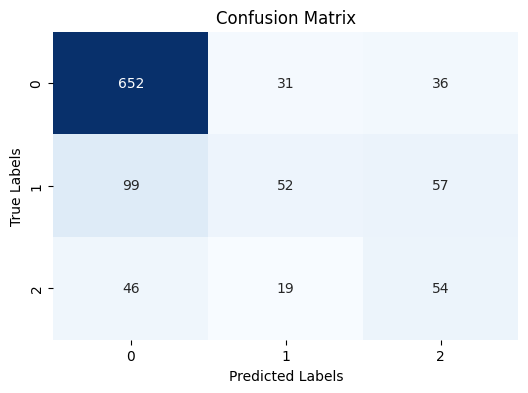


Class-wise Accuracy:
Class 0: Correct Predictions / Total True Samples = 652/719 (90.68%)
Class 1: Correct Predictions / Total True Samples = 52/208 (25.00%)
Class 2: Correct Predictions / Total True Samples = 54/119 (45.38%)

Precision-Recall Curves:


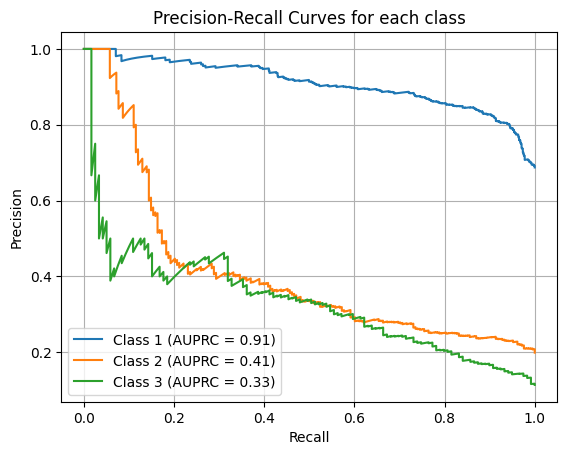


ROC Curves:


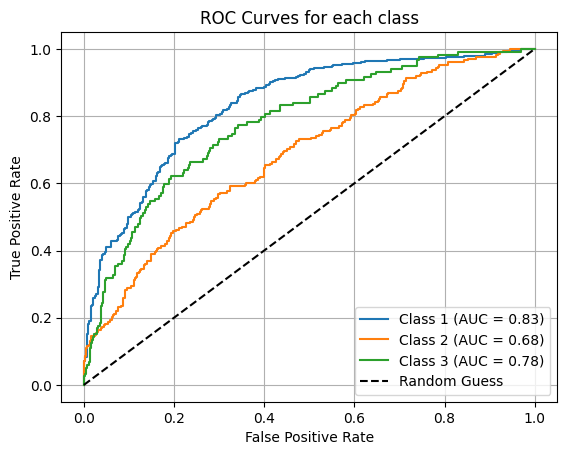


Mean F1 Score: 0.5339
Balanced Accuracy: 0.5369
Average AUPRC: 0.5494

Classification Report:
              precision    recall  f1-score   support

           0       0.82      0.91      0.86       719
           1       0.51      0.25      0.34       208
           2       0.37      0.45      0.41       119

    accuracy                           0.72      1046
   macro avg       0.57      0.54      0.53      1046
weighted avg       0.71      0.72      0.70      1046

Fold No: 2
Epoch [1/100], Loss: 1.1006, Accuracy: 0.3913
Validation Loss: 1.0850, Validation Accuracy: 0.4133
Epoch [2/100], Loss: 1.0573, Accuracy: 0.4942
Validation Loss: 1.0977, Validation Accuracy: 0.4651
Epoch [3/100], Loss: 1.0413, Accuracy: 0.5051
Validation Loss: 0.9941, Validation Accuracy: 0.4931
Epoch [4/100], Loss: 1.0249, Accuracy: 0.5225
Validation Loss: 1.0055, Validation Accuracy: 0.5012
Epoch [5/100], Loss: 1.0169, Accuracy: 0.5449
Validation Loss: 1.0504, Validation Accuracy: 0.5205
Epoch [6/100], Los

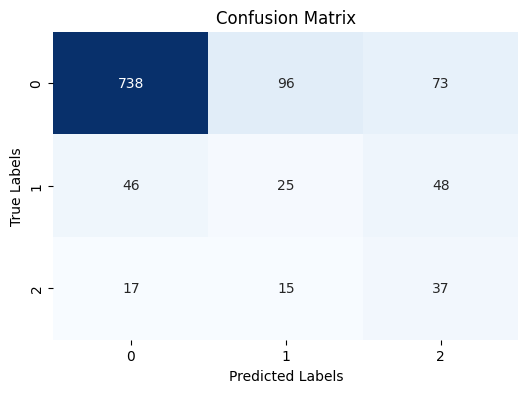


Class-wise Accuracy:
Class 0: Correct Predictions / Total True Samples = 738/907 (81.37%)
Class 1: Correct Predictions / Total True Samples = 25/119 (21.01%)
Class 2: Correct Predictions / Total True Samples = 37/69 (53.62%)

Precision-Recall Curves:


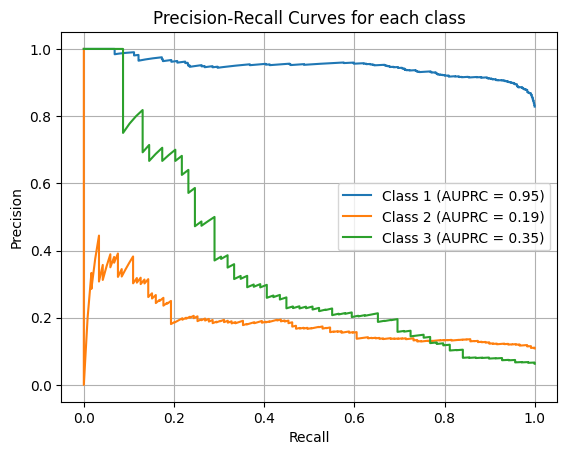


ROC Curves:


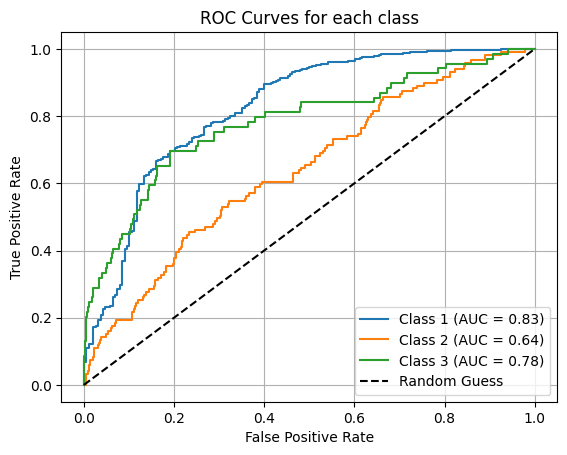


Mean F1 Score: 0.4621
Balanced Accuracy: 0.5200
Average AUPRC: 0.4953

Classification Report:
              precision    recall  f1-score   support

           0       0.92      0.81      0.86       907
           1       0.18      0.21      0.20       119
           2       0.23      0.54      0.33        69

    accuracy                           0.73      1095
   macro avg       0.45      0.52      0.46      1095
weighted avg       0.80      0.73      0.76      1095

Fold No: 3
Epoch [1/100], Loss: 1.1130, Accuracy: 0.3636
Validation Loss: 1.0380, Validation Accuracy: 0.4626
Epoch [2/100], Loss: 1.0808, Accuracy: 0.4382
Validation Loss: 0.9937, Validation Accuracy: 0.5127
Epoch [3/100], Loss: 1.0632, Accuracy: 0.4755
Validation Loss: 0.9980, Validation Accuracy: 0.4922
Epoch [4/100], Loss: 1.0471, Accuracy: 0.5074
Validation Loss: 1.0533, Validation Accuracy: 0.4938
Epoch [5/100], Loss: 1.0411, Accuracy: 0.5167
Validation Loss: 1.1784, Validation Accuracy: 0.4820
Epoch [6/100], Los

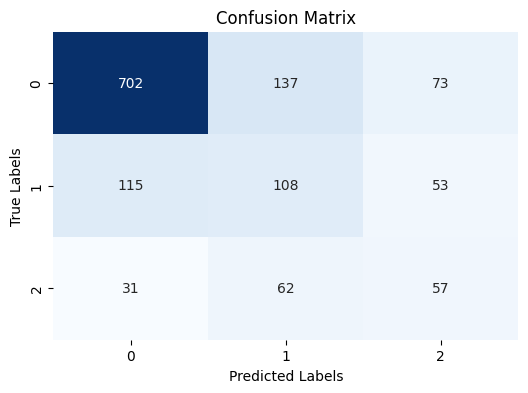


Class-wise Accuracy:
Class 0: Correct Predictions / Total True Samples = 702/912 (76.97%)
Class 1: Correct Predictions / Total True Samples = 108/276 (39.13%)
Class 2: Correct Predictions / Total True Samples = 57/150 (38.00%)

Precision-Recall Curves:


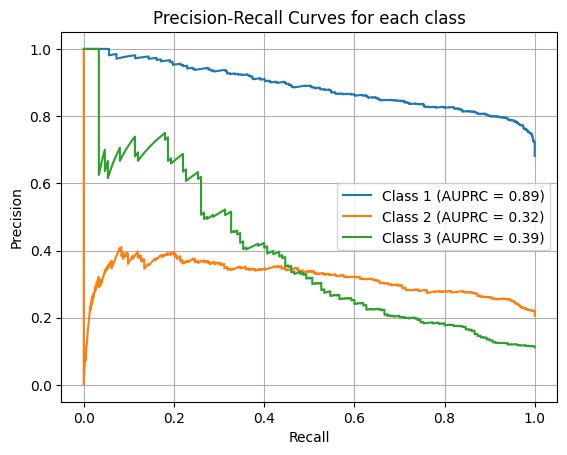


ROC Curves:


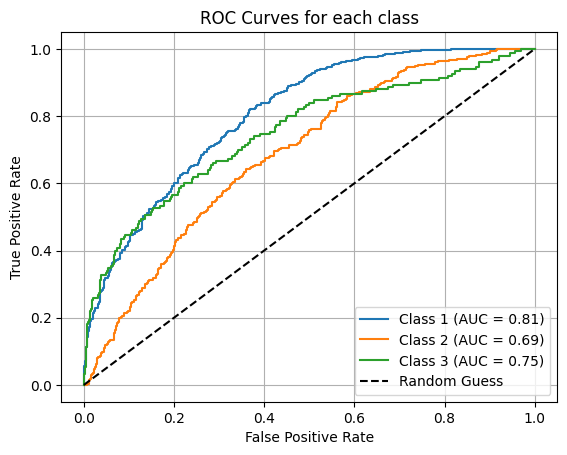


Mean F1 Score: 0.5035
Balanced Accuracy: 0.5137
Average AUPRC: 0.5308

Classification Report:
              precision    recall  f1-score   support

           0       0.83      0.77      0.80       912
           1       0.35      0.39      0.37       276
           2       0.31      0.38      0.34       150

    accuracy                           0.65      1338
   macro avg       0.50      0.51      0.50      1338
weighted avg       0.67      0.65      0.66      1338

Fold No: 4
Epoch [1/100], Loss: 1.0978, Accuracy: 0.4114
Validation Loss: 1.0670, Validation Accuracy: 0.5171
Epoch [2/100], Loss: 1.0637, Accuracy: 0.4663
Validation Loss: 1.1152, Validation Accuracy: 0.5363
Epoch [3/100], Loss: 1.0469, Accuracy: 0.5000
Validation Loss: 1.1406, Validation Accuracy: 0.5227
Epoch [4/100], Loss: 1.0544, Accuracy: 0.4778
Validation Loss: 0.9863, Validation Accuracy: 0.5276
Epoch [5/100], Loss: 1.0254, Accuracy: 0.5395
Validation Loss: 1.1119, Validation Accuracy: 0.5016
Epoch [6/100], Los

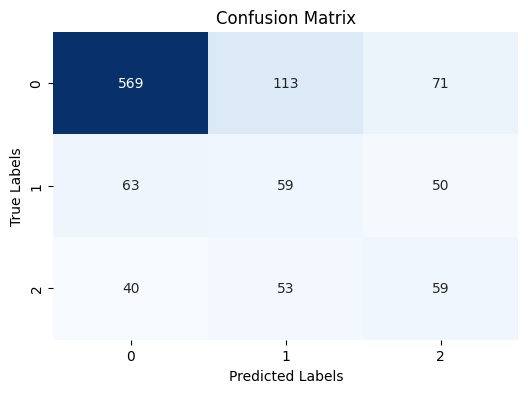


Class-wise Accuracy:
Class 0: Correct Predictions / Total True Samples = 569/753 (75.56%)
Class 1: Correct Predictions / Total True Samples = 59/172 (34.30%)
Class 2: Correct Predictions / Total True Samples = 59/152 (38.82%)

Precision-Recall Curves:


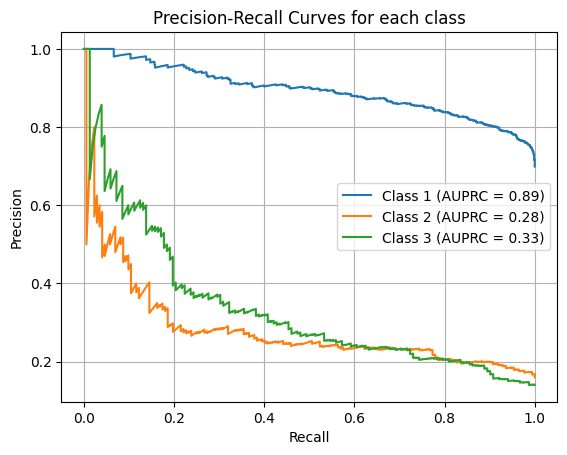


ROC Curves:


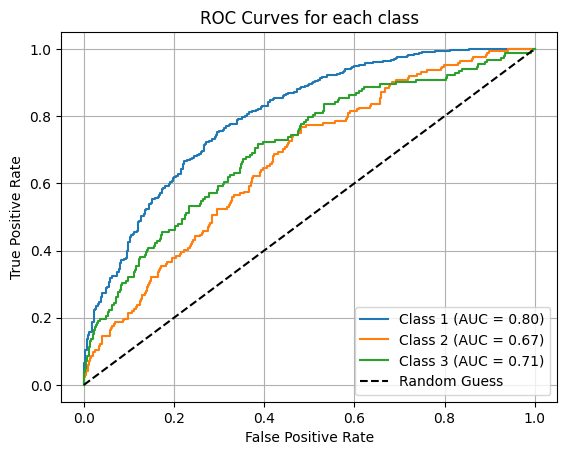


Mean F1 Score: 0.4837
Balanced Accuracy: 0.4956
Average AUPRC: 0.5024

Classification Report:
              precision    recall  f1-score   support

           0       0.85      0.76      0.80       753
           1       0.26      0.34      0.30       172
           2       0.33      0.39      0.36       152

    accuracy                           0.64      1077
   macro avg       0.48      0.50      0.48      1077
weighted avg       0.68      0.64      0.66      1077

Fold No: 5
Epoch [1/100], Loss: 1.1078, Accuracy: 0.4398
Validation Loss: 1.0619, Validation Accuracy: 0.4242
Epoch [2/100], Loss: 1.0405, Accuracy: 0.5306
Validation Loss: 1.1051, Validation Accuracy: 0.4058
Epoch [3/100], Loss: 1.0325, Accuracy: 0.5276
Validation Loss: 1.0670, Validation Accuracy: 0.4321
Epoch [4/100], Loss: 1.0165, Accuracy: 0.5611
Validation Loss: 1.0261, Validation Accuracy: 0.4602
Epoch [5/100], Loss: 1.0005, Accuracy: 0.5858
Validation Loss: 1.1190, Validation Accuracy: 0.4331
Epoch [6/100], Los

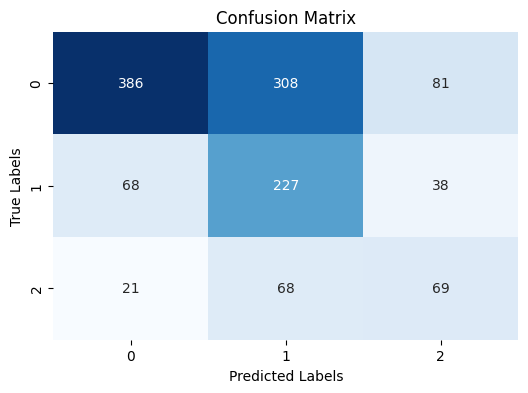


Class-wise Accuracy:
Class 0: Correct Predictions / Total True Samples = 386/775 (49.81%)
Class 1: Correct Predictions / Total True Samples = 227/333 (68.17%)
Class 2: Correct Predictions / Total True Samples = 69/158 (43.67%)

Precision-Recall Curves:


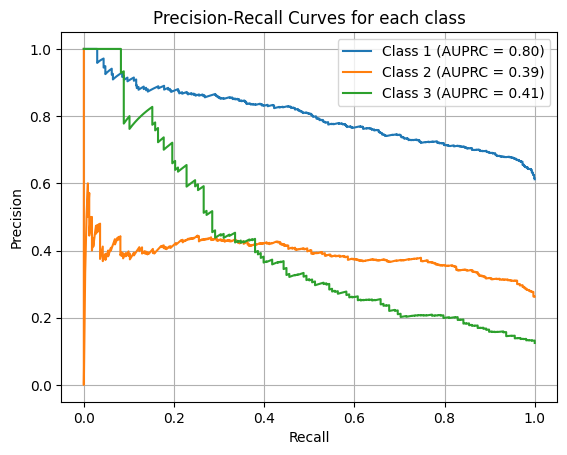


ROC Curves:


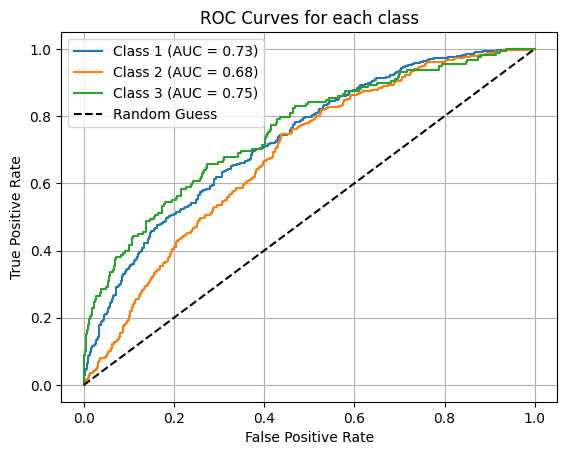


Mean F1 Score: 0.5005
Balanced Accuracy: 0.5388
Average AUPRC: 0.5335

Classification Report:
              precision    recall  f1-score   support

           0       0.81      0.50      0.62       775
           1       0.38      0.68      0.49       333
           2       0.37      0.44      0.40       158

    accuracy                           0.54      1266
   macro avg       0.52      0.54      0.50      1266
weighted avg       0.64      0.54      0.56      1266

Accuracy for each fold: [np.float64(0.5368655111557835), np.float64(0.5199957873311191), np.float64(0.5136803966437834), np.float64(0.4956084136187468), np.float64(0.5388183528567358)]
AUPRC for each fold: [np.float64(0.5494087537024768), np.float64(0.4953346866305783), np.float64(0.5308203589189526), np.float64(0.5024019115787757), np.float64(0.533471195530122)]
Average AUPRC across all folds: 0.5222873812721811
Average Balanced Accuracy across all folds: 0.5209936923212337
Results saved to D:\PYTHONIG\newwindow\NOTEB

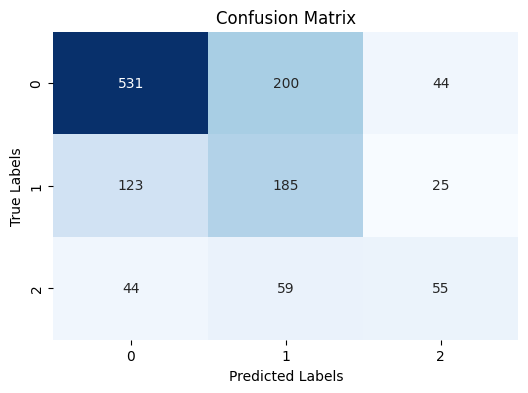


Class-wise Accuracy:
Class 0: Correct Predictions / Total True Samples = 531/775 (68.52%)
Class 1: Correct Predictions / Total True Samples = 185/333 (55.56%)
Class 2: Correct Predictions / Total True Samples = 55/158 (34.81%)

Precision-Recall Curves:


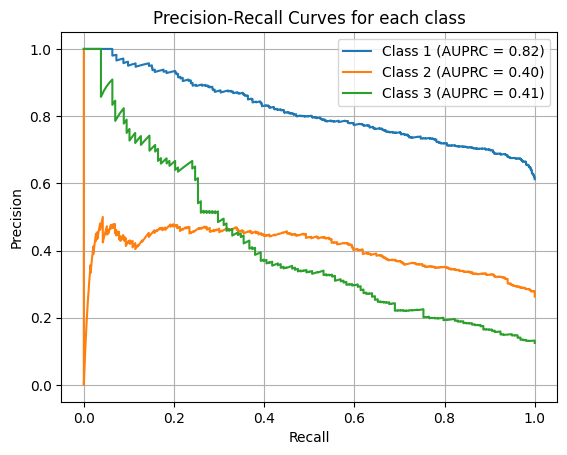


ROC Curves:


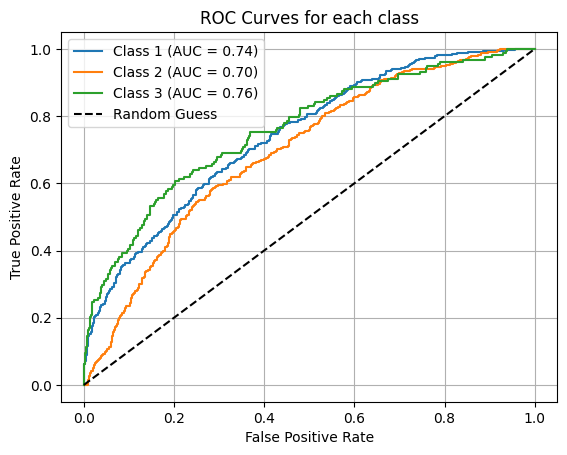


Mean F1 Score: 0.5291
Balanced Accuracy: 0.5296
Average AUPRC: 0.5431

Classification Report:
              precision    recall  f1-score   support

           0       0.76      0.69      0.72       775
           1       0.42      0.56      0.48       333
           2       0.44      0.35      0.39       158

    accuracy                           0.61      1266
   macro avg       0.54      0.53      0.53      1266
weighted avg       0.63      0.61      0.62      1266

Fold No: 2
Epoch [1/100], Loss: 1.1252, Accuracy: 0.3402
Validation Loss: 1.1369, Validation Accuracy: 0.3412
Epoch [2/100], Loss: 1.1015, Accuracy: 0.3895
Validation Loss: 1.1214, Validation Accuracy: 0.3828
Epoch [3/100], Loss: 1.0820, Accuracy: 0.4329
Validation Loss: 1.0662, Validation Accuracy: 0.4174
Epoch [4/100], Loss: 1.0711, Accuracy: 0.4694
Validation Loss: 1.1098, Validation Accuracy: 0.4623
Epoch [5/100], Loss: 1.0598, Accuracy: 0.4615
Validation Loss: 1.0772, Validation Accuracy: 0.4709
Epoch [6/100], Los

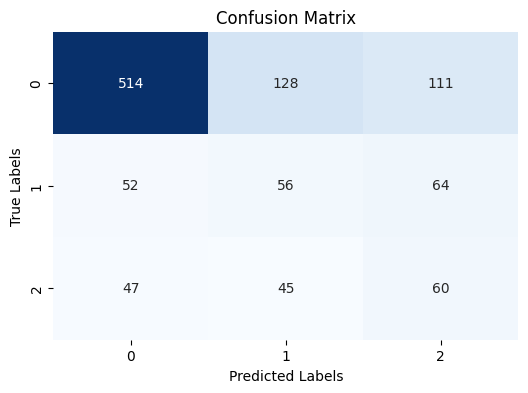


Class-wise Accuracy:
Class 0: Correct Predictions / Total True Samples = 514/753 (68.26%)
Class 1: Correct Predictions / Total True Samples = 56/172 (32.56%)
Class 2: Correct Predictions / Total True Samples = 60/152 (39.47%)

Precision-Recall Curves:


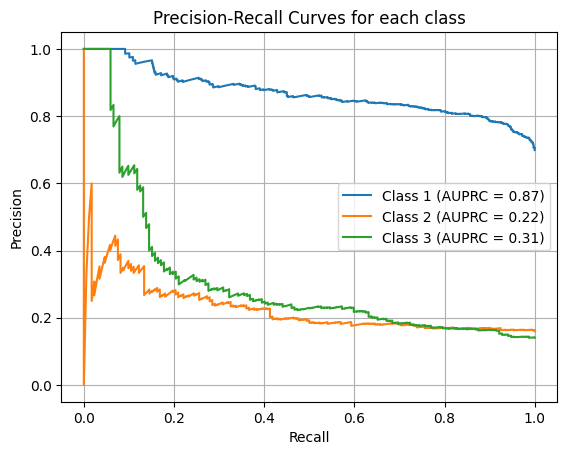


ROC Curves:


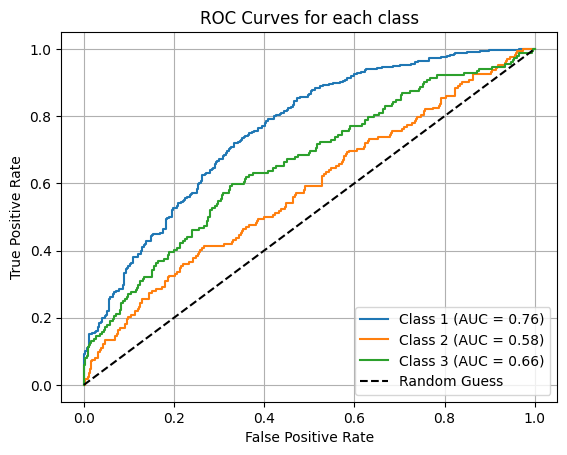


Mean F1 Score: 0.4473
Balanced Accuracy: 0.4676
Average AUPRC: 0.4662

Classification Report:
              precision    recall  f1-score   support

           0       0.84      0.68      0.75       753
           1       0.24      0.33      0.28       172
           2       0.26      0.39      0.31       152

    accuracy                           0.58      1077
   macro avg       0.45      0.47      0.45      1077
weighted avg       0.66      0.58      0.61      1077

Fold No: 3
Epoch [1/100], Loss: 1.1082, Accuracy: 0.3786
Validation Loss: 1.0887, Validation Accuracy: 0.3468
Epoch [2/100], Loss: 1.0975, Accuracy: 0.3825
Validation Loss: 1.1024, Validation Accuracy: 0.3696
Epoch [3/100], Loss: 1.0991, Accuracy: 0.3940
Validation Loss: 1.0613, Validation Accuracy: 0.3781
Epoch [4/100], Loss: 1.0777, Accuracy: 0.4268
Validation Loss: 1.0688, Validation Accuracy: 0.3921
Epoch [5/100], Loss: 1.0640, Accuracy: 0.4653
Validation Loss: 1.0531, Validation Accuracy: 0.4086
Epoch [6/100], Los

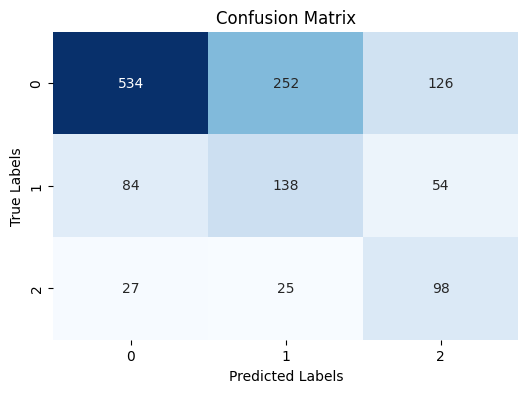


Class-wise Accuracy:
Class 0: Correct Predictions / Total True Samples = 534/912 (58.55%)
Class 1: Correct Predictions / Total True Samples = 138/276 (50.00%)
Class 2: Correct Predictions / Total True Samples = 98/150 (65.33%)

Precision-Recall Curves:


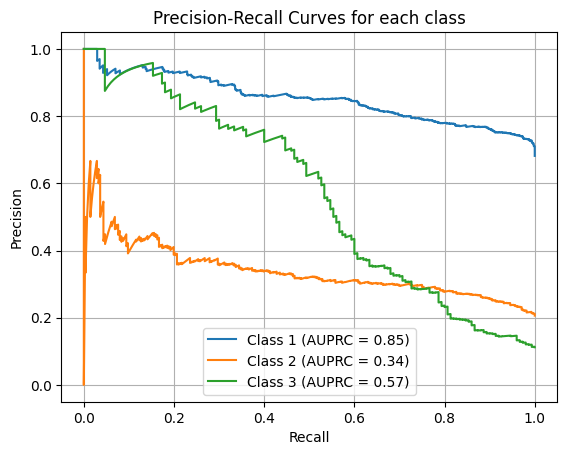


ROC Curves:


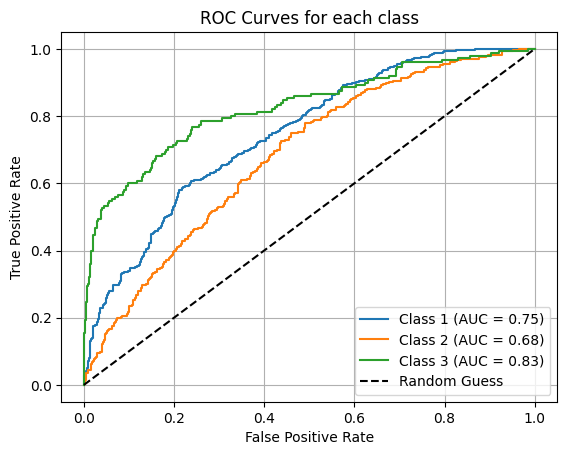


Mean F1 Score: 0.5144
Balanced Accuracy: 0.5796
Average AUPRC: 0.5853

Classification Report:
              precision    recall  f1-score   support

           0       0.83      0.59      0.69       912
           1       0.33      0.50      0.40       276
           2       0.35      0.65      0.46       150

    accuracy                           0.58      1338
   macro avg       0.50      0.58      0.51      1338
weighted avg       0.67      0.58      0.60      1338

Fold No: 4
Epoch [1/100], Loss: 1.1179, Accuracy: 0.3712
Validation Loss: 1.0436, Validation Accuracy: 0.3690
Epoch [2/100], Loss: 1.0917, Accuracy: 0.4072
Validation Loss: 1.0978, Validation Accuracy: 0.4270
Epoch [3/100], Loss: 1.0797, Accuracy: 0.4450
Validation Loss: 1.0233, Validation Accuracy: 0.4525
Epoch [4/100], Loss: 1.0789, Accuracy: 0.4310
Validation Loss: 1.0728, Validation Accuracy: 0.4982
Epoch [5/100], Loss: 1.0749, Accuracy: 0.4072
Validation Loss: 1.1283, Validation Accuracy: 0.4560
Epoch [6/100], Los

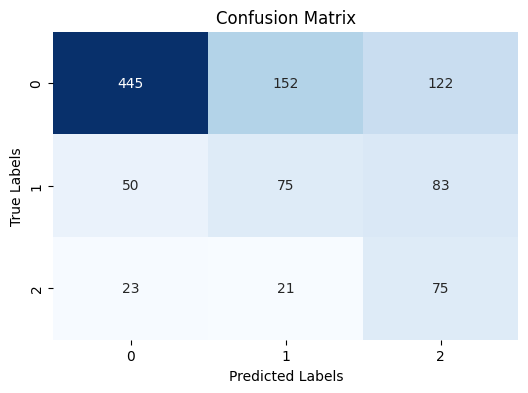


Class-wise Accuracy:
Class 0: Correct Predictions / Total True Samples = 445/719 (61.89%)
Class 1: Correct Predictions / Total True Samples = 75/208 (36.06%)
Class 2: Correct Predictions / Total True Samples = 75/119 (63.03%)

Precision-Recall Curves:


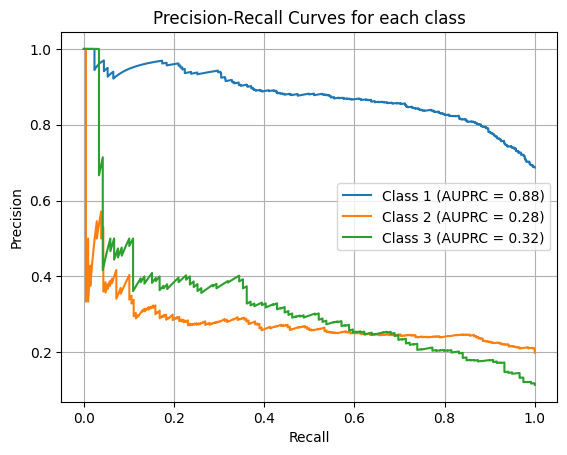


ROC Curves:


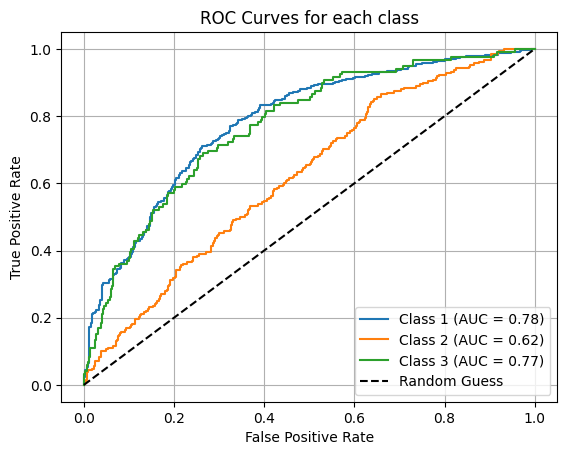


Mean F1 Score: 0.4748
Balanced Accuracy: 0.5366
Average AUPRC: 0.4914

Classification Report:
              precision    recall  f1-score   support

           0       0.86      0.62      0.72       719
           1       0.30      0.36      0.33       208
           2       0.27      0.63      0.38       119

    accuracy                           0.57      1046
   macro avg       0.48      0.54      0.47      1046
weighted avg       0.68      0.57      0.60      1046

Fold No: 5
Epoch [1/100], Loss: 1.1007, Accuracy: 0.4014
Validation Loss: 1.0465, Validation Accuracy: 0.3655
Epoch [2/100], Loss: 1.0927, Accuracy: 0.4130
Validation Loss: 1.0685, Validation Accuracy: 0.4050
Epoch [3/100], Loss: 1.0783, Accuracy: 0.4413
Validation Loss: 1.0391, Validation Accuracy: 0.4432
Epoch [4/100], Loss: 1.0727, Accuracy: 0.4616
Validation Loss: 1.0425, Validation Accuracy: 0.4633
Epoch [5/100], Loss: 1.0627, Accuracy: 0.4623
Validation Loss: 1.0539, Validation Accuracy: 0.4676
Epoch [6/100], Los

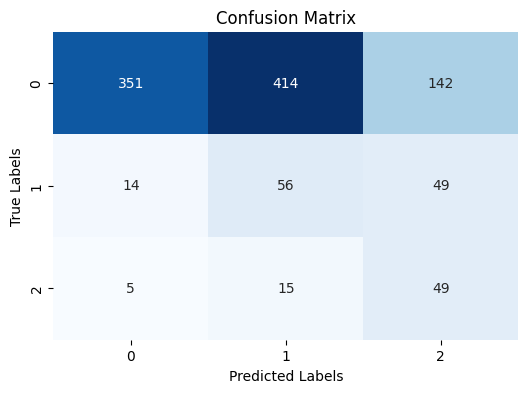


Class-wise Accuracy:
Class 0: Correct Predictions / Total True Samples = 351/907 (38.70%)
Class 1: Correct Predictions / Total True Samples = 56/119 (47.06%)
Class 2: Correct Predictions / Total True Samples = 49/69 (71.01%)

Precision-Recall Curves:


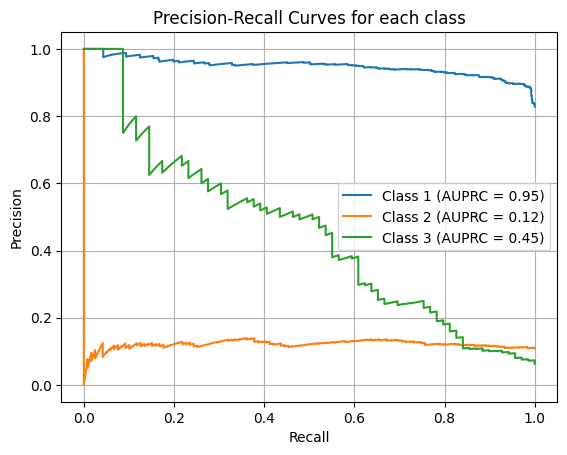


ROC Curves:


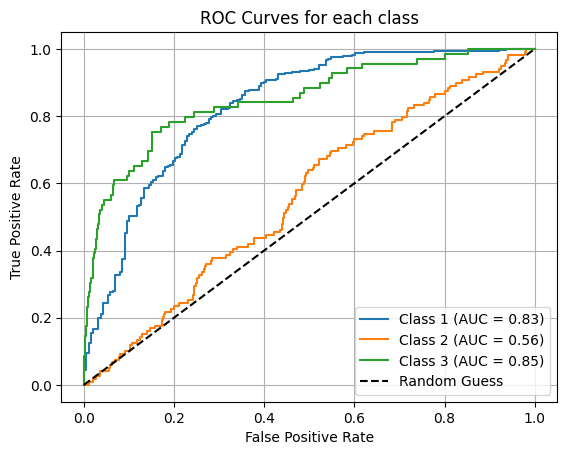


Mean F1 Score: 0.3508
Balanced Accuracy: 0.5226
Average AUPRC: 0.5066

Classification Report:
              precision    recall  f1-score   support

           0       0.95      0.39      0.55       907
           1       0.12      0.47      0.19       119
           2       0.20      0.71      0.32        69

    accuracy                           0.42      1095
   macro avg       0.42      0.52      0.35      1095
weighted avg       0.81      0.42      0.50      1095

Accuracy for each fold: [np.float64(0.5296060372336404), np.float64(0.46764038636694893), np.float64(0.5796198830409357), np.float64(0.5365813946205421), np.float64(0.5225744133359526)]
AUPRC for each fold: [np.float64(0.5431377605827374), np.float64(0.4662265232286708), np.float64(0.5853368906088309), np.float64(0.49141281998633923), np.float64(0.5065778794939586)]
Average AUPRC across all folds: 0.5185383747801074
Average Balanced Accuracy across all folds: 0.5272044229196039
Results saved to D:\PYTHONIG\newwindow\NO

In [9]:
import pandas as pd
import os
import datetime

import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.metrics import balanced_accuracy_score, confusion_matrix
from sklearn.preprocessing import label_binarize
from sklearn.metrics import precision_recall_curve, auc


top_params = [
    {
        "trial": 33,
        "accuracy": 0.4955,
        "hyperparameters": {
            "ff_dim": 32,
            "dropout_rate": 0.22443843372647287,
            "embed_dim": 2048,
            "learning_rate": 2.4511558646364287e-06,
            "optimizer": "Adam",
            "weight_decay": 7.92277168064745e-06,
            "batch_size": 16,
            "num_heads": 8,
            "num_transformer_blocks": 1
        }
    },
    {
        "trial": 43,
        "accuracy": 0.4937,
        "hyperparameters": {
            "ff_dim": 32,
            "dropout_rate": 0.3252336776552044,
            "embed_dim": 1024,
            "learning_rate": 6.686685908069584e-07,
            "optimizer": "Adam",
            "weight_decay": 8.953824798122134e-06,
            "batch_size": 16,
            "num_heads": 4,
            "num_transformer_blocks": 1
        }
    },
    {
        "trial": 18,
        "accuracy": 0.4905,
        "hyperparameters": {
            "ff_dim": 128,
            "dropout_rate": 0.1223412597644731,
            "embed_dim": 256,
            "learning_rate": 2.5821821760623193e-06,
            "optimizer": "Adam",
            "weight_decay": 6.253454290522161e-05,
            "batch_size": 16,
            "num_heads": 8,
            "num_transformer_blocks": 1
        }
    },
    {
        "trial": 28,
        "accuracy": 0.4863,
        "hyperparameters": {
            "ff_dim": 32,
            "dropout_rate": 0.14076357351667868,
            "embed_dim": 2048,
            "learning_rate": 1.0796649749079528e-06,
            "optimizer": "Adam",
            "weight_decay": 1.7975839086129747e-05,
            "batch_size": 16,
            "num_heads": 8,
            "num_transformer_blocks": 1
        }
    },
    {
        "trial": 24,
        "accuracy": 0.4831,
        "hyperparameters": {
            "ff_dim": 128,
            "dropout_rate": 0.14350736709418738,
            "embed_dim": 2048,
            "learning_rate": 3.4574917812589834e-07,
            "optimizer": "Adam",
            "weight_decay": 1.360877349977649e-05,
            "batch_size": 16,
            "num_heads": 8,
            "num_transformer_blocks": 1
        }
    }
]


for param_id in range(len(top_params)):
    # Fold indices and other configurations
    
    print(f"Running experiment with parameters:{param_id} {top_params[param_id]}")
    print("_"*50)
    print("_"*50)
    print("_"*50)
    print("_"*50)
    print("_"*50)    
    
    num_folds = 5
    fold_indices = np.random.permutation(np.arange(num_folds))
    val_fold_indices = np.roll(fold_indices, 1)

    test_folds_chosen = []
    val_folds_chosen = []
    fold_confusion_matrices = []  # To store confusion matrices for each fold
    fold_accuracies = []  # To store balanced accuracy for each fold
    fold_auprcs = []  # To store AUPRC for each fold

    # Model and training configurations
    num_classes = 3
    learning_rate = 0.0001
    epochs = 100
    input_shape = (3, 224, 224)  # (channels, height, width)
    device = 'cuda' if torch.cuda.is_available() else 'cpu'




    embed_dim = top_params[param_id]["hyperparameters"]["embed_dim"]
    learning_rate = top_params[param_id]["hyperparameters"]["learning_rate"]
    num_heads = top_params[param_id]["hyperparameters"]["num_heads"]
    ff_dim = top_params[param_id]["hyperparameters"]["ff_dim"]
    num_transformer_blocks = top_params[param_id]["hyperparameters"]["num_transformer_blocks"]
    dropout_rate = top_params[param_id]["hyperparameters"]["dropout_rate"]
    batch_size = top_params[param_id]["hyperparameters"]["batch_size"]
    weight_decay = top_params[param_id]["hyperparameters"]["weight_decay"]

    def save_results_to_csv(fold_accuracies, fold_auprcs, fold_confusion_matrices, model_info, csv_path=r"F:\CODING\py\newnotebooks\results.csv"):
        """
        Save all results from the current experiment to a CSV file
        
        Parameters:
        - fold_accuracies: list of balanced accuracy scores for each fold
        - fold_auprcs: list of AUPRC scores for each fold
        - fold_confusion_matrices: list of confusion matrices for each fold
        - model_info: string with model architecture description
        - csv_path: path to the CSV file to save results
        """
        # Current time for experiment identification
        timestamp = datetime.datetime.now().strftime("%Y-%m-%d %H:%M:%S")
        
        # Prepare data for the DataFrame
        data = {
            "timestamp": timestamp,
            "model_info": model_info,
            "num_classes": num_classes,
            "learning_rate": learning_rate,
            "epochs": epochs,
            "mean_balanced_accuracy": np.mean(fold_accuracies),
            "std_balanced_accuracy": np.std(fold_accuracies),
            "mean_auprc": np.mean(fold_auprcs),
            "std_auprc": np.std(fold_auprcs),
        }
        
        # Add individual fold results
        for i, (acc, auprc) in enumerate(zip(fold_accuracies, fold_auprcs)):
            data[f"fold_{i+1}_accuracy"] = acc
            data[f"fold_{i+1}_auprc"] = auprc
        
        # Add confusion matrix info
        for i, cm in enumerate(fold_confusion_matrices):
            data[f"fold_{i+1}_confusion_matrix"] = str(cm)
        
        # Create DataFrame and append to CSV
        df = pd.DataFrame([data])
        
        # Check if file exists
        file_exists = os.path.isfile(csv_path)
        
        # Save to CSV
        if file_exists:
            df.to_csv(csv_path, mode='a', header=False, index=False)
        else:
            df.to_csv(csv_path, mode='w', header=True, index=False)
        
        print(f"Results saved to {csv_path}")
        
        



    # Training loop for cross-validation
    for fold_idx in range(num_folds):
        print(f'Fold No: {fold_idx + 1}')
        
        # Initialize model, loss, and optimizer
        fold_model = TransformerModel(input_shape=input_shape, num_classes=num_classes,
                                    embed_dim=embed_dim, num_heads=num_heads, ff_dim=ff_dim,
                                    num_transformer_blocks=num_transformer_blocks, dropout_rate=dropout_rate).to(device)

        
        criterion = nn.CrossEntropyLoss(label_smoothing=0.3)
        optimizer = optim.Adam(fold_model.parameters(), lr=learning_rate, weight_decay=weight_decay)
        
        # Split data into train, validation, and test sets
        test_fold = fold_indices[fold_idx]
        val_fold = val_fold_indices[fold_idx]
        train_folds = [fold for fold in fold_indices if fold != test_fold and fold != val_fold]

        train_data = np.concatenate([eeg_folds[j] for j in train_folds])
        train_labels = np.concatenate([labels_folds[j] for j in train_folds])
        train_data = train_data.transpose(0, 3, 1, 2)  # Transpose to match PyTorch input format

        test_folds_chosen.append(test_fold)
        val_folds_chosen.append(val_fold)
        
        early_stopping = EarlyStopping(patience=10)
        
        # Training loop
        for epoch in range(epochs):
            balanced_train_data, balanced_train_labels = data_balancer(train_data, train_labels, factor=1)

            train_dataset = TensorDataset(
                torch.tensor(balanced_train_data, dtype=torch.float32).to(device),
                torch.tensor(balanced_train_labels, dtype=torch.long).to(device)
            )
            train_loader = DataLoader(train_dataset, batch_size=10, shuffle=True)
            
            fold_model.train()
            running_loss = 0.0
            all_preds = []
            all_labels = []
            
            for inputs, labels in train_loader:
                optimizer.zero_grad()
                outputs = fold_model(inputs)
                loss = criterion(outputs, labels)
                loss.backward()
                optimizer.step()
                
                running_loss += loss.item()
                _, preds = torch.max(outputs, 1)
                all_preds.extend(preds.cpu().numpy())
                all_labels.extend(labels.cpu().numpy())
                
            epoch_loss = running_loss / len(train_loader)
            epoch_acc = balanced_accuracy_score(all_labels, all_preds)
            print(f'Epoch [{epoch + 1}/{epochs}], Loss: {epoch_loss:.4f}, Accuracy: {epoch_acc:.4f}')

            # Validation loop
            val_data = eeg_folds[val_fold].transpose(0, 3, 1, 2)
            val_labels = labels_folds[val_fold]
            val_dataset = TensorDataset(
                torch.tensor(val_data, dtype=torch.float32).to(device),
                torch.tensor(val_labels, dtype=torch.long).to(device)
            )
            val_loader = DataLoader(val_dataset, batch_size=10, shuffle=False)

            fold_model.eval()
            val_loss = 0.0
            val_preds = []
            val_labels_list = []

            with torch.no_grad():
                for val_inputs, val_labels in val_loader:
                    val_outputs = fold_model(val_inputs)
                    loss = criterion(val_outputs, val_labels)
                    val_loss += loss.item()

                    _, val_batch_preds = torch.max(val_outputs, 1)
                    val_preds.extend(val_batch_preds.cpu().numpy())
                    val_labels_list.extend(val_labels.cpu().numpy())

            val_loss /= len(val_loader)
            val_acc = balanced_accuracy_score(val_labels_list, val_preds)
            print(f'Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_acc:.4f}')

            early_stopping(val_loss, fold_model)
            if early_stopping.early_stop:
                print("Early stopping")
                break

        # Load the best model
        early_stopping.load_best_model(fold_model)

        # Test loop
        test_data = eeg_folds[test_fold].transpose(0, 3, 1, 2)
        test_labels = labels_folds[test_fold]
        test_dataset = TensorDataset(
            torch.tensor(test_data, dtype=torch.float32).to(device),
            torch.tensor(test_labels, dtype=torch.long).to(device)
        )
        test_loader = DataLoader(test_dataset, batch_size=10, shuffle=False)

        fold_model.eval()
        test_probs = []
        test_preds = []
        test_labels_list = []

        with torch.no_grad():
            for test_inputs, test_labels in test_loader:
                test_outputs = fold_model(test_inputs)
                probabilities = torch.softmax(test_outputs, dim=1)
                test_probs.extend(probabilities.cpu().numpy())
                _, preds = torch.max(probabilities, 1)
                test_preds.extend(preds.cpu().numpy())
                test_labels_list.extend(test_labels.cpu().numpy())

        # Compute metrics
        test_acc = balanced_accuracy_score(test_labels_list, test_preds)
        fold_accuracies.append(test_acc)

        cm = confusion_matrix(test_labels_list, test_preds)
        fold_confusion_matrices.append(cm)

        test_labels_binarized = label_binarize(test_labels_list, classes=np.arange(num_classes))
        test_auprcs = []
        for class_idx in range(num_classes):
            precision, recall, _ = precision_recall_curve(test_labels_binarized[:, class_idx], np.array(test_probs)[:, class_idx])
            auprc = auc(recall, precision)
            test_auprcs.append(auprc)

        mean_test_auprc = np.mean(test_auprcs)
        fold_auprcs.append(mean_test_auprc)

        print(f'Test Fold {fold_idx + 1}, Mean AUPRC: {mean_test_auprc:.4f}, Balanced Accuracy: {test_acc:.4f}')

        # Use the plot_metrics function to visualize metrics
        plot_metrics(np.array(test_labels_list), np.array(test_probs), n_classes=num_classes)

    # Final metrics across all folds
    average_auprc = np.mean(fold_auprcs)
    mean_accuracy = np.mean(fold_accuracies)
    print(f'Accuracy for each fold: {fold_accuracies}')
    print(f'AUPRC for each fold: {fold_auprcs}')
    print(f'Average AUPRC across all folds: {average_auprc}')
    print(f'Average Balanced Accuracy across all folds: {mean_accuracy}')
        
    # Save all results to CSV
    save_path = r"D:\PYTHONIG\newwindow\NOTEBOOKS_2025\aprilmay2025\newnotebooks\results.csv"
    model_description = f"TRANSformer MEL top5 param#{param_id} 3 classes"
    save_results_to_csv(fold_accuracies, fold_auprcs, fold_confusion_matrices, model_description, csv_path=save_path)
    
    print("_"*50)
    print("_"*50)
    print("_"*50)
    print("_"*50)
    print("_"*50)  